# Steam Game Positivity Prediction

In [126]:
import kagglehub
import pandas as pd
import os
import io
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ast
import re
import string
import math

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import VarianceThreshold


In [127]:
# Download dataset
path = kagglehub.dataset_download("fronkongames/steam-games-dataset")
print("Path to dataset files:", path)

# Find CSV file
files = os.listdir(path)
csv_file = [f for f in files if f.endswith('.csv')][0]
csv_path = os.path.join(path, csv_file)

# Read and patch the file
with open(csv_path, 'r', encoding='utf-8') as f:
    lines = f.readlines()

# Fix the broken header (only applies to first line usually)
lines[0] = lines[0].replace("DiscountDLC count", "Discount,DLC count")

# Load the fixed content into a DataFrame
df_raw = pd.read_csv(io.StringIO(''.join(lines)))

Path to dataset files: C:\Users\wille\.cache\kagglehub\datasets\fronkongames\steam-games-dataset\versions\30


These are some Helper Functions to help with cleanoing the data

In [132]:
def normalize_label(label):
    if not isinstance(label, str):
        return label
    label = label.strip().lower()                       # lowercase and trim whitespace
    label = label.strip(string.punctuation)             # remove punctuation from start/end
    label = re.sub(r'\s+', ' ', label)                  # collapse multiple spaces
    # Optionally add manual fixes here, e.g.:
    # if label in ['ltd', 'ltd.']:
    #     return 'ltd'
    return label

def clean_list_items(items):
    cleaned = []
    for item in items:
        if not item:
            continue
        item_clean = item.strip()
        item_clean = re.sub(r"^[\[\('\"]+|[\]\)'\"]+$", "", item_clean)
        item_clean = normalize_label(item_clean)
        if item_clean:
            cleaned.append(item_clean)
    return cleaned

def parse_comma_separated_list(x):
    if isinstance(x, list):
        return clean_list_items(x)
    if isinstance(x, str):
        items = [item.strip() for item in x.split(',') if item.strip()]
        return clean_list_items(items)
    return []

def filter_valid_target(df, target_column):
    # Keep only rows where target is not 0 and not NaN
    filtered_df = df[(df[target_column].notna()) & (df[target_column] != 0)]
    
    print(f"Total rows with valid '{target_column}': {len(filtered_df)}")
    return filtered_df

def filter_unrated_reviews(df, category_column='Review_Category'):
    filtered_df = df[df[category_column] != "Unrated"]
    print(f"Rows with rated reviews: {len(filtered_df)} (Removed {len(df) - len(filtered_df)} unrated rows)")
    return filtered_df

def flatten_and_split_language_list(x):
    if isinstance(x, list):
        # Sometimes languages might be nested lists or strings inside lists, flatten them
        flattened = []
        for item in x:
            if isinstance(item, list):
                flattened.extend(item)
            elif isinstance(item, str):
                flattened.append(item)
        return flattened
    elif isinstance(x, str):
        # If it's a string, split by commas and strip whitespace
        return [lang.strip() for lang in x.split(',')]
    else:
        # Return empty list for NaN or unexpected types
        return []
    
def filter_outliers(df, feature, target, lower_percentile=0.01, upper_percentile=0.99):
    lower_f = df[feature].quantile(lower_percentile)
    upper_f = df[feature].quantile(upper_percentile)
    lower_t = df[target].quantile(lower_percentile)
    upper_t = df[target].quantile(upper_percentile)
    
    return df[(df[feature] >= lower_f) & (df[feature] <= upper_f) &
              (df[target] >= lower_t) & (df[target] <= upper_t)]

def filter_outliers_iqr(df, column, drop_zeros=False):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    if drop_zeros:
        filtered = filtered[filtered[column] > 0]
    return filtered

def count_screenshots(value):
    if pd.isna(value):
        return 0
    if isinstance(value, str):
        return value.count("http")
    if isinstance(value, list):
        return len(value)
    return 0


def count_movies(value):
    if pd.isna(value):
        return 0
    # Try to evaluate stringified list/dicts safely
    if isinstance(value, str):
        try:
            value = ast.literal_eval(value)
        except Exception:
            # Fallback: count URLs
            return value.count("http")
    if isinstance(value, list):
        return len(value)
    return 0


In [133]:
max_x_row = df_raw.loc[df_raw['Negative'].idxmax()]

# Print the game's name and X count
print(f"Game with most Xs: {max_x_row['Name']} ({max_x_row['Negative']} X)")

Game with most Xs: PUBG: BATTLEGROUNDS (895978 X)


In [134]:
#I wanted to see which columns had the most Nan values

nan_counts = df_raw.isna().sum().sort_values(ascending=False)
print(nan_counts[nan_counts > 0])

Score rank        110282
Metacritic url    106405
Reviews            99780
Notes              92075
Website            64264
Support url        60028
Pos_neg_ratio      57044
Tags               36950
Support email      18809
Movies              9528
Categories          7543
Publishers          6748
About the game      6460
Developers          6452
Genres              6423
Screenshots         4174
Name                   1
dtype: int64


AppId, 'AppID', 'Screenshots', 'Movies', 'Header image', 'Support email', 'Support url', 'Website', 'Notes' , 'Reviews', 'About the game', 'Name', 'Peak CCU' Are all not too important
Others like 'Score rank' contain too many Nan values.

In [135]:
#There are a few duplicate titles. I get rid of them and only take the first one
duplicate_names = df_raw[df_raw.duplicated(subset='Name', keep=False)]
print(f"Found {duplicate_names.shape[0]} rows with duplicate names.")
df_raw = df_raw.drop_duplicates(subset='Name', keep='first')

#Lets add some features
df_raw['Title length'] = df_raw['Name'].astype(str).apply(len)
df_raw['Title_word_count'] = df_raw['Name'].astype(str).apply(lambda x: len(x.split()))
df_raw['Title_avg_word_len'] = df_raw['Name'].astype(str).apply(lambda x: (sum(len(word) for word in x.split()) / max(len(x.split()), 1)))
df_raw['Title Has Number'] = df_raw['Name'].astype(str).apply(lambda x: int(any(char.isdigit() for char in x)))
df_raw['Title_First_Letter'] = df_raw['Name'].astype(str).str[0].str.upper().fillna('Unknown')
df_raw['HasWebsite'] = df_raw['Website'].notna().astype(int)
df_raw['HasSupport'] = (df_raw['Support email'].notna() | df_raw['Website'].notna()).astype(int)
df_raw['Description length'] = df_raw['About the game'].astype(str).apply(len)
df_raw['Description_word_count'] = df_raw['About the game'].astype(str).apply(lambda x: len(x.split()))
df_raw['Description_First_Letter'] = df_raw['About the game'].astype(str).str[0].str.upper().fillna('Unknown')
df_raw['Num_Screenshots'] = df_raw['Screenshots'].apply(count_screenshots)
df_raw['Num_Movies'] = df_raw['Movies'].apply(count_movies)
df_raw['Description_punct_count'] = df_raw['About the game'].astype(str).apply(lambda x: sum(ch in string.punctuation for ch in x))

# One-hot encode the first-letter columns
df_raw = pd.get_dummies(df_raw, columns=['Title_First_Letter', 'Description_First_Letter'],
                        prefix=['TitleLetter', 'DescLetter'], dtype=int)

#Lets drop these columns
drop_cols = ['AppID', 'Screenshots', 'Movies', 'Header image', 'Support email', 'Support url',
             'Website', 'Notes', 'Metacritic url', 'Discount', 'Score rank', 'Reviews',
             'About the game', 'Name', 'Average playtime two weeks', 'Median playtime two weeks'
             ,'Peak CCU', 'User score']
df = df_raw.drop(columns=drop_cols)

#I change the date to simply the year
df['Release date'] = pd.to_datetime(df['Release date'], errors='coerce')
df['Release_year'] = df['Release date'].dt.year.fillna(0).astype(int)
reference_date = pd.Timestamp("2023-07-04")     #When the data ends
df['Days_since_release'] = (reference_date - df['Release date']).dt.days

# Drop original date column
df.drop(columns=['Release date'], inplace=True)

# Lets make sure these columns are correct Numeric columns
df['Positive'] = pd.to_numeric(df['Positive'], errors='coerce')     # Number of positive reviews
df['Negative'] = pd.to_numeric(df['Negative'], errors='coerce')     # Number of negative reviews
df['Required age'] = pd.to_numeric(df['Required age'], errors='coerce')     # Age requirement
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')                   # Game price
df['Average playtime forever'] = pd.to_numeric(df['Average playtime forever'], errors='coerce')     # Avg total playtime for all users
df['Median playtime forever'] = pd.to_numeric(df['Median playtime forever'], errors='coerce')       # Median total playtime for all users
df['Recommendations'] = pd.to_numeric(df['Recommendations'], errors='coerce')                 # Number of recommendations
df['Metacritic score'] = pd.to_numeric(df['Metacritic score'], errors='coerce')             # Score from Metacritic, 0 if it does not exist
df['DLC count'] = pd.to_numeric(df['DLC count'], errors='coerce') 
df['Achievements'] = pd.to_numeric(df['Achievements'], errors='coerce')     

#Lets change the Boolean values to ints
bool_features = ['Windows', 'Mac', 'Linux']     #If they're supported by these systems
df[bool_features] = df[bool_features].astype(int)
df['PlatformSupport_count'] = df[bool_features].sum(axis=1)     #Total number of systems the game is supported on

# Drop rows with no rating data, as zero here means no information
df = df[
    (df['Positive'] > 0) &
    (df['Negative'] > 0) 
]

# Create PositivityRate column as well as total number of reviews column and review categories
df['Number Of Reviews'] = (df['Positive'] + df['Negative'])
df['PositivityRate'] = df['Positive'] / df['Number Of Reviews']
df['PositivityRate'] = df['PositivityRate'].fillna(0)
df['Review_Difference'] = df['Positive'] - df['Negative']
df['Review_Difference'] = df['Review_Difference'].replace([np.inf, -np.inf], np.nan)
df_raw['Pos_neg_ratio'] = df['Positive'] / (df['Negative'] + 1)

def get_review_category(row):
    total = row['Number Of Reviews']
    perc = row['PositivityRate']
    
    # Handle missing or invalid data
    if pd.isna(perc):
        return "Unrated"

    if total >= 500:
        if perc >= 0.95:
            return "Overwhelmingly Positive"
        elif perc >= 0.8:
            return "Very Positive"
        elif perc >= 0.7:
            return "Mostly Positive"
        elif perc >= 0.4:
            return "Mixed"
        elif perc < 0.2:
            return "Overwhelmingly Negative"
        else:
            return "Very Negative"

    elif 50 <= total < 500:
        if perc >= 0.8:
            return "Very Positive"
        elif perc >= 0.7:
            return "Mostly Positive"
        elif perc >= 0.4:
            return "Mixed"
        elif perc < 0.2:
            return "Very Negative"
        else:
            return "Negative"

    elif 10 <= total < 50:
        if perc >= 0.8:
            return "Positive"
        elif perc >= 0.7:
            return "Mostly Positive"
        elif perc >= 0.4:
            return "Mixed"
        elif perc < 0.2:
            return "Negative"
        else:
            return "Unrated"

    return "Unrated"

df['Review_Category'] = df.apply(get_review_category, axis=1)

def get_review_category_simplified(row):
    perc = row['PositivityRate']
    total = row['Number Of Reviews']
    
    # Handle missing or invalid data
    if pd.isna(perc):
        return "Unrated"

    # Main simplified categories
    if(total >= 10):
        if perc >= 0.8:
            return "Positive"
        elif perc >= 0.7:
            return "Mostly Positive"
        elif perc >= 0.4:
            return "Mixed"
        elif perc >= 0.2:
            return "Mostly Negative"
        else:
            return "Negative"
    else:
        return "Unrated"

df['Review_Category_Simplified'] = df.apply(get_review_category_simplified, axis=1)

# Apply the function to Supported and Full audio languages
df['Supported languages'] = df['Supported languages'].apply(flatten_and_split_language_list)
df['Full audio languages'] = df['Full audio languages'].apply(flatten_and_split_language_list)

# Combine and count unique languages
df['Languages'] = df.apply(lambda row: list(set(row['Supported languages'] + row['Full audio languages'])), axis=1)
df.drop(columns=['Supported languages', 'Full audio languages'], inplace=True)

# One-hot encode the top 200 categorical features, place the rest in "other"
important_category_count = 200

list_like_features = ['Languages', 'Categories', 'Genres', 'Tags', 'Developers', 'Publishers']
for col in list_like_features:
    df[col] = df[col].apply(parse_comma_separated_list)
    df[f'{col}_count'] = df[col].apply(len)

df['Languages_count'] = df['Languages'].apply(len)

mlb_dict = {}

def get_top_n_labels(series, n):
    all_labels = series.explode()
    top_labels = all_labels.value_counts().head(n).index.tolist()
    return set(top_labels)

for col in list_like_features:
    df[col] = df[col].apply(lambda x: x if isinstance(x, list) else [])
    
    top_labels = get_top_n_labels(df[col], n = important_category_count)

    # Filter each list to contain only top labels
    df[f"{col}_filtered"] = df[col].apply(
    lambda x: [item for item in x if item in top_labels] +
              ([f"{col}_Other"] if any(item not in top_labels for item in x) else [])
    )

    mlb = MultiLabelBinarizer()
    transformed = mlb.fit_transform(df[f"{col}_filtered"])
    ohe_cols = [f"{col}_{cls}" for cls in mlb.classes_]

    df_ohe = pd.DataFrame(transformed, columns=ohe_cols, index=df.index)
    df = pd.concat([df, df_ohe], axis=1)

    mlb_dict[col] = mlb

# drop the intermediate filtered columns
df.drop(columns=[f"{col}_filtered" for col in list_like_features], inplace=True)
# Drop the original list-like columns
df.drop(columns=list_like_features, inplace=True)

#Remove similar genre and tags, as a lot of the tags and genres are the same

# Step 1: Identify Genre_ and Tag_ columns
genre_cols = [col for col in df.columns if col.startswith("Genres_")]
tag_cols = [col for col in df.columns if col.startswith("Tags_")]
# Step 2: Normalize suffixes (e.g., "Genres_Action" → "action")
genre_suffixes = {col.split("Genres_")[1]: col for col in genre_cols}
tag_suffixes = {col.split("Tags_")[1]: col for col in tag_cols}
# Step 3: Find overlapping suffixes
common_suffixes = set(genre_suffixes.keys()) & set(tag_suffixes.keys())
# Step 4: Merge common tags and genres
for suffix in common_suffixes:
    new_col = f"Genre_{suffix}"
    df[new_col] = df[genre_suffixes[suffix]] | df[tag_suffixes[suffix]]  # OR logic to combine
    df.drop(columns=[genre_suffixes[suffix], tag_suffixes[suffix]], inplace=True)
# Step 5: Rename remaining unique genres/tags
for suffix in set(genre_suffixes.keys()) - common_suffixes:
    df.rename(columns={genre_suffixes[suffix]: f"Genre_{suffix}"}, inplace=True)
for suffix in set(tag_suffixes.keys()) - common_suffixes:
    df.rename(columns={tag_suffixes[suffix]: f"Genre_{suffix}"}, inplace=True)

#Lets count a few of the categorical features for extra information
df['Categories_count'] = pd.to_numeric(df['Categories_count'], errors='coerce')
df['Number Of Reviews'] = pd.to_numeric(df['Number Of Reviews'], errors='coerce') 
df['PlatformSupport_count'] = pd.to_numeric(df['PlatformSupport_count'], errors='coerce') 

#Remove Nans and weird columns
df.drop(columns=['Estimated owners_count'], inplace=True, errors='ignore')
df = df[df['Release_year'] != 0]
df = df.dropna()

Found 0 rows with duplicate names.


In [136]:
#Features preview
print(f"Final number of features (columns): {df.shape[1]}")
print(f"Number of samples (rows): {df.shape[0]}")
print("First 10 feature names:")
print(list(df.columns[:20]))

Final number of features (columns): 5082
Number of samples (rows): 53178
First 10 feature names:
['Estimated owners', 'Required age', 'Price', 'DLC count', 'Windows', 'Mac', 'Linux', 'Metacritic score', 'Positive', 'Negative', 'Achievements', 'Recommendations', 'Average playtime forever', 'Median playtime forever', 'Title length', 'Title_word_count', 'Title_avg_word_len', 'Title Has Number', 'HasWebsite', 'HasSupport']


In [137]:
#List of values we want to try and pridict
Main_targets = ['PositivityRate', 'Metacritic score', 'Review_Category', 'Review_Category_Simplified', 'Review_Difference', 'Pos_neg_ratio'] 
additional_targets = ['Estimated owners', 'Recommendations', 'Positive', 'Negative', 'Number Of Reviews', 'Average playtime forever', 'Median playtime forever']

numerical_targets = ['PositivityRate', 'Metacritic score', 'Recommendations', 'Positive', 'Negative', 'Number Of Reviews', 'Average playtime forever', 'Median playtime forever']
categorical_targets = ['Review_Category', 'Review_Category_Simplified', 'Estimated owners']

targets = set(Main_targets + additional_targets)

features = [col for col in df.columns if col not in targets]

#Non binary or categorical features
numeric_features = df.select_dtypes(include='number')
numeric_features = numeric_features.loc[:, (numeric_features.nunique() > 2)]

With so many features, lets remove the low Variance ones

In [138]:
def remove_low_variance_features(df, threshold=0.0, exclude_columns=None):
    if exclude_columns is None:
        exclude_columns = []

    numeric = df.select_dtypes(include=['number'])
    numeric_to_check = numeric.drop(columns=exclude_columns, errors='ignore')

    selector = VarianceThreshold(threshold)
    selector.fit(numeric_to_check)

    retained = numeric_to_check.columns[selector.get_support()]
    retained = list(retained) + [col for col in exclude_columns if col in df.columns]

    return df[retained]

df = remove_low_variance_features(df, threshold=0.01, exclude_columns = targets)

print(f"Final number of features (columns): {df.shape[1]}")
print(f"Number of samples (rows): {df.shape[0]}")
print("First 10 feature names:")
print(list(df.columns[:20]))

Final number of features (columns): 470
Number of samples (rows): 53178
First 10 feature names:
['Required age', 'Price', 'DLC count', 'Mac', 'Linux', 'Achievements', 'Title length', 'Title_word_count', 'Title_avg_word_len', 'Title Has Number', 'HasWebsite', 'HasSupport', 'Description length', 'Description_word_count', 'Num_Screenshots', 'Num_Movies', 'Description_punct_count', 'TitleLetter_A', 'TitleLetter_A', 'TitleLetter_B']


Lets check for and remove correlated features

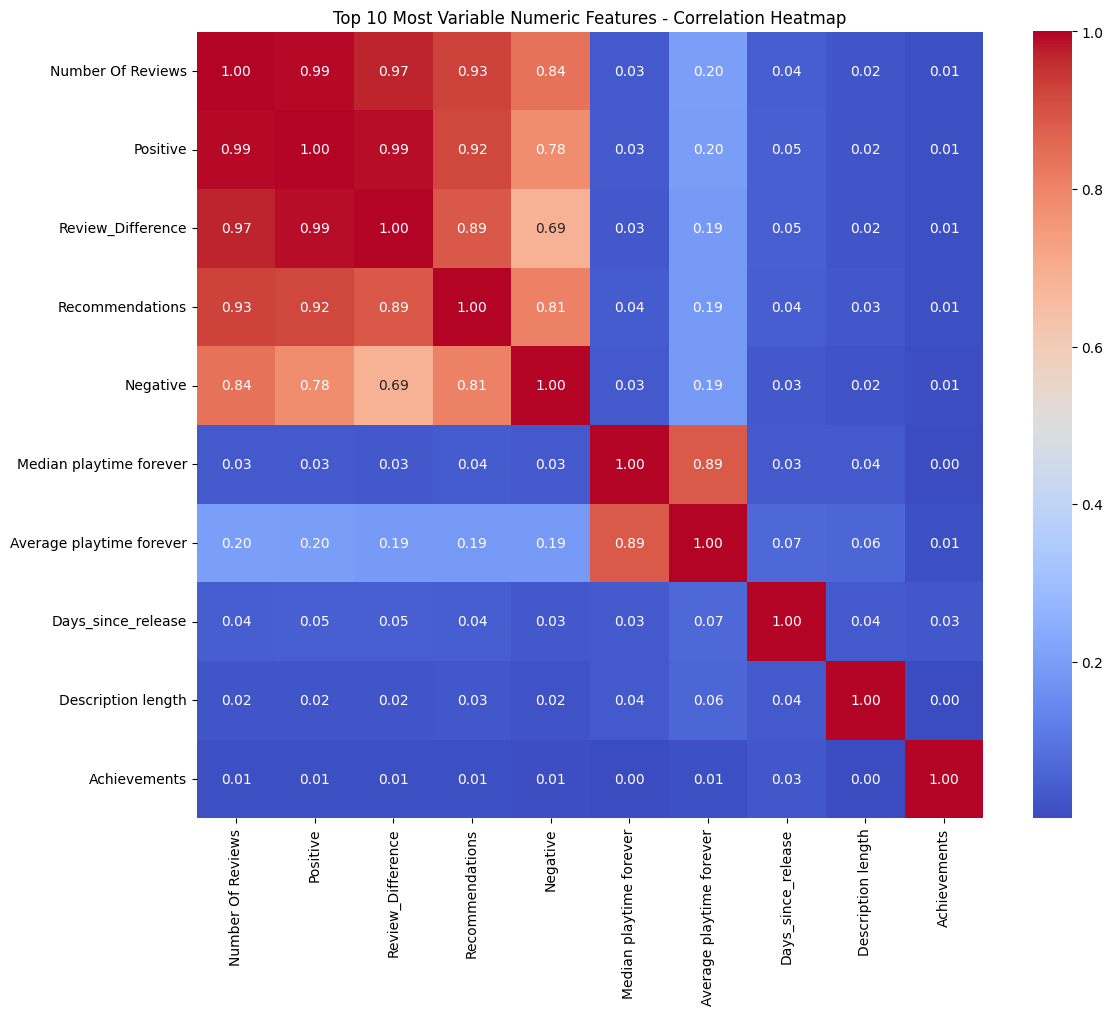

In [139]:
def plot_feature_correlations(df, top_n=10):
    numeric_df = df.select_dtypes(include=['number'])
    corr = numeric_df.corr().abs()

    # Select top_n features with highest variance to keep the plot readable
    top_features = numeric_df.var().sort_values(ascending=False).head(top_n).index
    corr_top = corr.loc[top_features, top_features]

    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_top, annot=True, fmt=".2f", cmap="coolwarm", square=True)
    plt.title(f"Top {top_n} Most Variable Numeric Features - Correlation Heatmap")
    plt.tight_layout()
    plt.show()

plot_feature_correlations(df, top_n=10)

In [140]:
def remove_highly_correlated_features(df, threshold=0.95, exclude_columns=None):
    if exclude_columns is None:
        exclude_columns = []

    numeric_df = df.select_dtypes(include=['number']).drop(columns=exclude_columns, errors='ignore')
    corr_matrix = numeric_df.corr().abs()

    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    to_drop = set()
    for col in upper.columns:
        for row in upper.index:
            if upper.loc[row, col] is not np.nan and upper.loc[row, col] > threshold:
                # Drop 'col' (or could pick 'row' depending on strategy)
                to_drop.add(col)
                break  # only drop one feature per column once found

    print(f"🔍 Removing {len(to_drop)} highly correlated features with threshold > {threshold}")
    return df.drop(columns=list(to_drop)), list(to_drop)

print(f"Final number of features (columns): {df.shape[1]}")
print(f"Number of samples (rows): {df.shape[0]}")
print("First 10 feature names:")
print(list(df.columns[:20]))

Final number of features (columns): 470
Number of samples (rows): 53178
First 10 feature names:
['Required age', 'Price', 'DLC count', 'Mac', 'Linux', 'Achievements', 'Title length', 'Title_word_count', 'Title_avg_word_len', 'Title Has Number', 'HasWebsite', 'HasSupport', 'Description length', 'Description_word_count', 'Num_Screenshots', 'Num_Movies', 'Description_punct_count', 'TitleLetter_A', 'TitleLetter_A', 'TitleLetter_B']


In [141]:
print(df.columns.tolist())
print(f"{len(df)} rows")
print("===========================")
print(df.describe(include='all'))
print("===========================")
print(df.head(2))

print(df['Languages_count'].value_counts())

['Required age', 'Price', 'DLC count', 'Mac', 'Linux', 'Achievements', 'Title length', 'Title_word_count', 'Title_avg_word_len', 'Title Has Number', 'HasWebsite', 'HasSupport', 'Description length', 'Description_word_count', 'Num_Screenshots', 'Num_Movies', 'Description_punct_count', 'TitleLetter_A', 'TitleLetter_A', 'TitleLetter_B', 'TitleLetter_B', 'TitleLetter_C', 'TitleLetter_C', 'TitleLetter_D', 'TitleLetter_D', 'TitleLetter_E', 'TitleLetter_E', 'TitleLetter_F', 'TitleLetter_F', 'TitleLetter_G', 'TitleLetter_G', 'TitleLetter_H', 'TitleLetter_H', 'TitleLetter_I', 'TitleLetter_I', 'TitleLetter_K', 'TitleLetter_K', 'TitleLetter_L', 'TitleLetter_L', 'TitleLetter_M', 'TitleLetter_M', 'TitleLetter_N', 'TitleLetter_N', 'TitleLetter_O', 'TitleLetter_O', 'TitleLetter_P', 'TitleLetter_P', 'TitleLetter_R', 'TitleLetter_R', 'TitleLetter_S', 'TitleLetter_S', 'TitleLetter_T', 'TitleLetter_T', 'TitleLetter_U', 'TitleLetter_U', 'TitleLetter_V', 'TitleLetter_V', 'TitleLetter_W', 'TitleLetter_W', "

In [143]:
all_targets = Main_targets + additional_targets + numerical_targets + categorical_targets
unique_targets = set(all_targets)  # Remove duplicates

existing_cols = [col for col in unique_targets if col in df.columns]
missing_cols = [col for col in unique_targets if col not in df.columns]

print("Existing columns in df:")
print(existing_cols)

print("\nMissing columns in df:")
print(missing_cols)

#Reset the features now that some got removed

targets = set(Main_targets + additional_targets)

features = [col for col in df.columns if col not in targets]

Existing columns in df:
['Metacritic score', 'Average playtime forever', 'PositivityRate', 'Recommendations', 'Number Of Reviews', 'Estimated owners', 'Review_Category', 'Positive', 'Review_Difference', 'Median playtime forever', 'Negative', 'Pos_neg_ratio', 'Review_Category_Simplified']

Missing columns in df:
[]


In [116]:
def summarize_review_difference(df, column='Review_Difference'):
    data = df[column].dropna()

    summary = data.describe()  # count, mean, std, min, quartiles, max

    print(f"Summary statistics for '{column}':")
    print(summary.to_string())

    print(f"\nAdditional statistics:")
    print(f"Number of zeros: {(data == 0).sum()}")
    print(f"Number of positive values: {(data > 0).sum()}")
    print(f"Number of negative values: {(data < 0).sum()}")
    print(f"Unique values count: {data.nunique()}")

summarize_review_difference(df)

Summary statistics for 'Review_Difference':
count    5.317800e+04
mean     1.253752e+03
std      2.626863e+04
min     -6.691700e+04
25%      3.000000e+00
50%      1.700000e+01
75%      1.000000e+02
max      4.997743e+06

Additional statistics:
Number of zeros: 2504
Number of positive values: 44089
Number of negative values: 6585
Unique values count: 4472


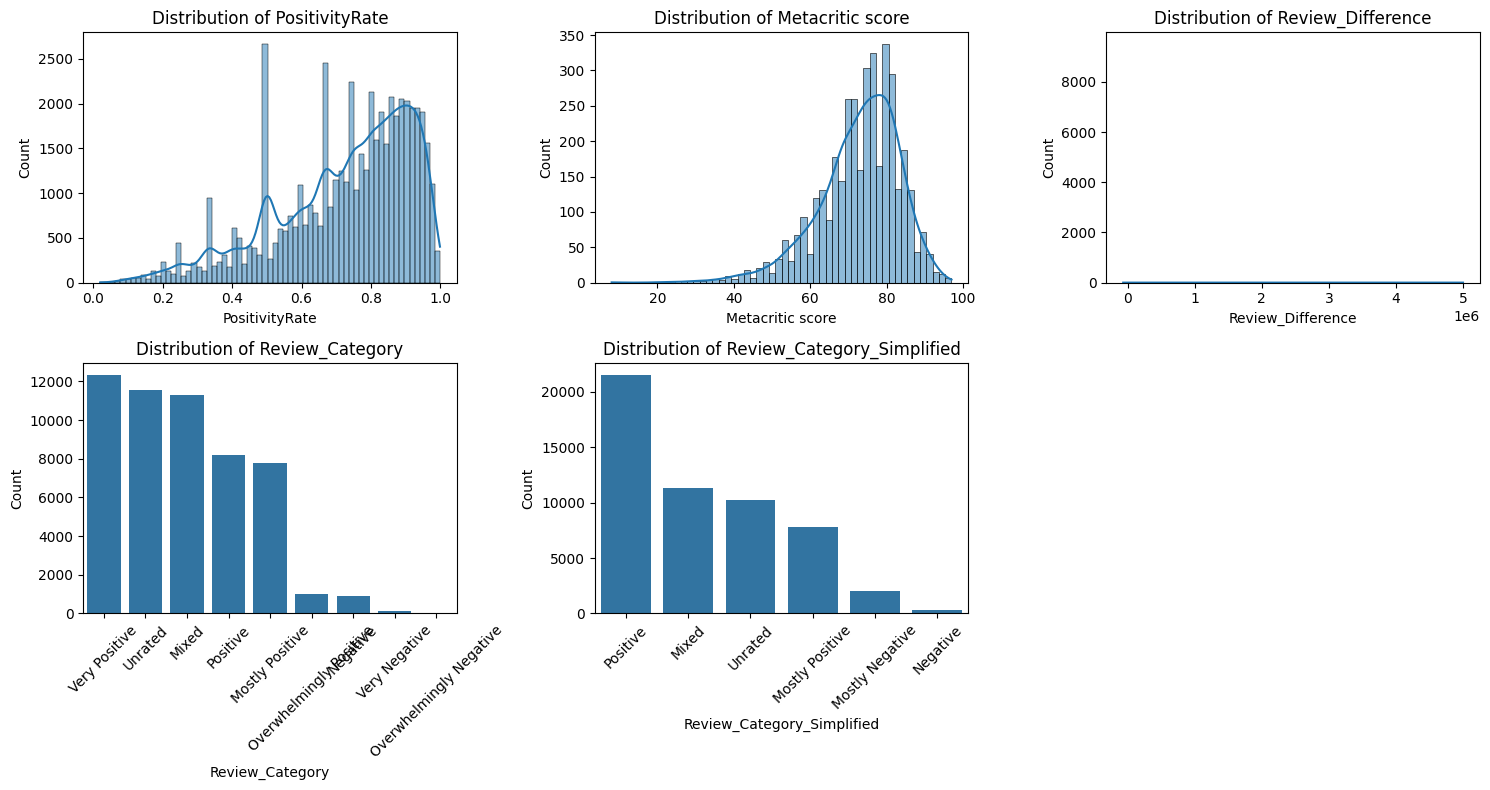

In [117]:
def quick_plot_distributions(df, numerical_targets, categorical_targets):
    total_targets = numerical_targets + categorical_targets
    n_targets = len(total_targets)
    cols = 3
    rows = math.ceil(n_targets / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
    axes = axes.flatten()

    for i, target in enumerate(total_targets):
        ax = axes[i]

        if target in numerical_targets:
            if target == 'Metacritic score':
                data = df[df[target] != 0][target].dropna()
            else:
                data = df[target].dropna()

            sns.histplot(data, kde=True, ax=ax)
            ax.set_title(f"Distribution of {target}")
            ax.set_xlabel(target)
            ax.set_ylabel("Count")

        else:  # categorical
            order = df[target].value_counts().index
            sns.countplot(data=df, x=target, order=order, ax=ax)
            ax.set_title(f"Distribution of {target}")
            ax.set_xlabel(target)
            ax.set_ylabel("Count")
            ax.tick_params(axis='x', rotation=45)

    # Turn off unused axes if any
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


main_numerical_targets = ['PositivityRate', 'Metacritic score', 'Review_Difference']
main_categorical_targets = ['Review_Category', 'Review_Category_Simplified']

quick_plot_distributions(df, main_numerical_targets, main_categorical_targets)

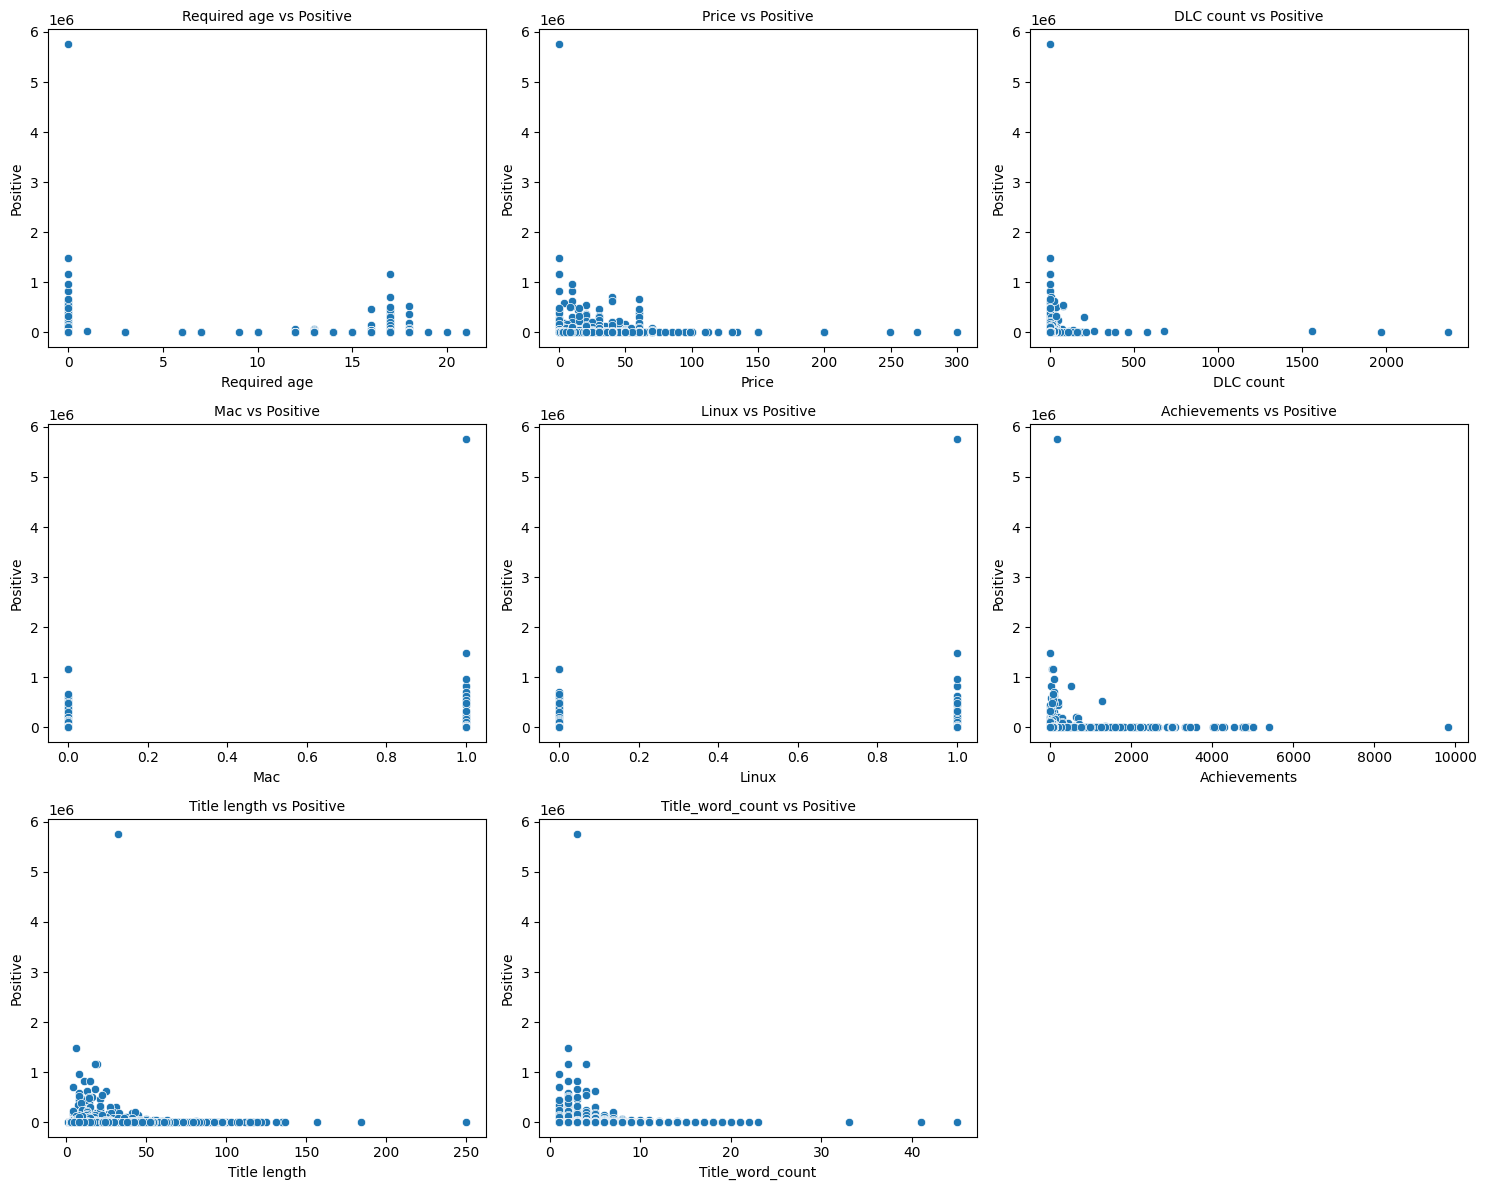

In [118]:
def plot_features_vs_target(df, target='Positive', n_features=8):
    # Select numeric features, exclude the target and non-numeric columns
    numeric_features = df.select_dtypes(include=['number']).columns.drop([target], errors='ignore')
    
    # Select the first n_features for plotting
    feature_columns = numeric_features[:n_features]

    # Setup subplot grid
    cols = 3
    rows = math.ceil(len(feature_columns) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
    axes = axes.flatten()

    # Plot each feature against the target
    for i, feature in enumerate(feature_columns):
        sns.scatterplot(data=df, x=feature, y=target, ax=axes[i])
        axes[i].set_title(f"{feature} vs {target}", fontsize=10)
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel(target)

    # Turn off any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

plot_features_vs_target(df, target='Positive', n_features=8)

In [119]:
#Potentially tried changing some to logs

#df['DLC count'] = np.log1p(df['DLC count'])
#df['Price'] = np.log1p(df['Price'])
#df['Positive'] = np.log1p(df['Positive'])
#df['Languages_count'] = np.log1p(df['Languages_count'])
#df['Negative'] = np.log1p(df['Negative'])
#df['Num_Screenshots'] = np.log1p(df['Num_Screenshots'])
#df['Num_Movies'] = np.log1p(df['Num_Movies'])
#df['Average playtime forever'] = np.log1p(df['Average playtime forever'])
#df['Median playtime forever'] = np.log1p(df['Median playtime forever'])
#df['Achievements'] = np.log1p(df['Achievements'])

Lets Start Modeling! First we need to figure out what features are important

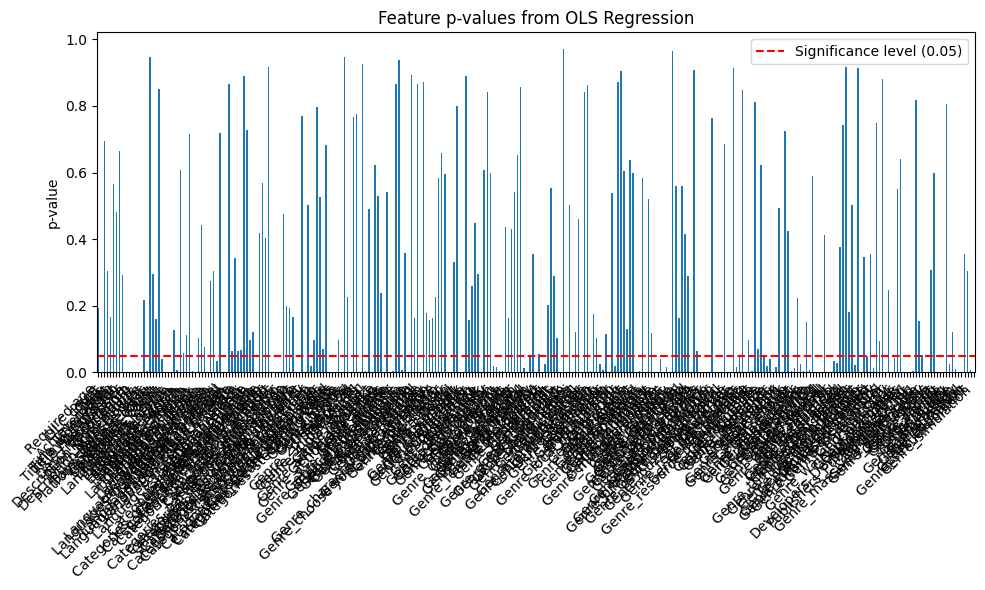

In [144]:
def plot_feature_pvalues(df, features, target, alpha=0.05):
    numeric_features = [col for col in features if pd.api.types.is_numeric_dtype(df[col])]
    X = df[numeric_features]
    y = df[target]

    # Add intercept for OLS
    X = sm.add_constant(X)

    model = sm.OLS(y, X).fit()

    # Extract p-values (skip the intercept 'const')
    pvalues = model.pvalues.drop('const')

    # Plot
    plt.figure(figsize=(10, 6))
    pvalues.plot(kind='bar')
    plt.axhline(y=0.05, color='r', linestyle='--', label='Significance level (0.05)')
    plt.ylabel('p-value')
    plt.title('Feature p-values from OLS Regression')
    plt.legend()
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Filter significant features
    significant_features = pvalues[pvalues < alpha].index.tolist()

    return significant_features, model.summary()

significant_features, summary = plot_feature_pvalues(df, features, 'PositivityRate')



In [145]:
def adjusted_r2(r2, n, k):
    return 1 - (1 - r2) * (n - 1) / (n - k - 1) if n > k + 1 else r2

Lets do Forwads, backwards, and mixed feature selection

In [146]:
def forward_stepwise_selection(df, all_features, target_col, cv=5, min_r2_improvement = 0.001, plot=False, verbose=True):
    y = df[target_col].values
    X_all = df[all_features]

    remaining_features = list(all_features)
    selected_features = []

    n_samples = len(y)

    # Track metrics
    metrics = {
        'r2_cv': [], 'adj_r2_cv': [],
        'mae_cv': [], 'mse_cv': [], 'rmse_cv': [],
        'num_features': []
    }

    best_scores = {
        'r2': {'score': -np.inf, 'features': [], 'model': None},
        'mae': {'score': np.inf, 'features': [], 'model': None},
        'mse': {'score': np.inf, 'features': [], 'model': None},
        'rmse': {'score': np.inf, 'features': [], 'model': None}
    }

    if verbose:
        print(f"\nStarting Forward Stepwise Selection for target: '{target_col}'")
        print("-" * 60)

    while remaining_features:
        scores = []

        for feat in remaining_features:
            try_features = selected_features + [feat]

            model = LinearRegression()

            # Use cross_val_predict to get predictions on all data via CV folds
            kf = KFold(n_splits=cv, shuffle=True, random_state=42)
            y_pred_cv = cross_val_predict(model, X_all[try_features], y, cv=kf)

            # Calculate metrics on CV predictions
            r2 = r2_score(y, y_pred_cv)
            mae = mean_absolute_error(y, y_pred_cv)
            mse = mean_squared_error(y, y_pred_cv)
            rmse = np.sqrt(mse)

            scores.append((r2, mae, mse, rmse, feat))
        # Sort by R² descending to pick best feature
        scores.sort(key=lambda x: x[0], reverse=True)
        best_r2, best_mae, best_mse, best_rmse, best_feat = scores[0]

        selected_features.append(best_feat)
        remaining_features.remove(best_feat)

        # Fit model on full data with selected features
        final_model = LinearRegression().fit(X_all[selected_features], y)
        y_pred_full = final_model.predict(X_all[selected_features])

        # Calculate adjusted R²
        adj_r2 = adjusted_r2(best_r2, n_samples, len(selected_features))

        # Save metrics
        metrics['r2_cv'].append(best_r2)
        metrics['adj_r2_cv'].append(adj_r2)
        metrics['mae_cv'].append(best_mae)
        metrics['mse_cv'].append(best_mse)
        metrics['rmse_cv'].append(best_rmse)
        metrics['num_features'].append(len(selected_features))

        # Track best models by metrics
        if best_r2 > best_scores['r2']['score']:
            best_scores['r2'].update({'score': best_r2, 'features': list(selected_features), 'model': final_model})
        if best_mae < best_scores['mae']['score']:
            best_scores['mae'].update({'score': best_mae, 'features': list(selected_features), 'model': final_model})
        if best_mse < best_scores['mse']['score']:
            best_scores['mse'].update({'score': best_mse, 'features': list(selected_features), 'model': final_model})
        if best_rmse < best_scores['rmse']['score']:
            best_scores['rmse'].update({'score': best_rmse, 'features': list(selected_features), 'model': final_model})

        if verbose:
            print(f"Added: {best_feat:<30} R² CV: {best_r2:.4f} | Adj R²: {adj_r2:.4f} | MAE CV: {best_mae:.4f} | MSE CV: {best_mse:.4f} | RMSE CV: {best_rmse:.4f}")

        # You can add a stopping criterion here if you want (e.g., no improvement or max features)
        if len(metrics['r2_cv']) > 1:
            delta_r2 = metrics['r2_cv'][-1] - metrics['r2_cv'][-2]
            if delta_r2 < min_r2_improvement:
                if verbose:
                    print(f"🔹 Stopping early: R² improvement {delta_r2:.6f} is less than threshold {min_r2_improvement}")
                break
    if verbose:
        print("-" * 60)
        print("Best subsets by metric:")
        for metric, data in best_scores.items():
            print(f"  {metric.upper()}: {data['score']:.4f} with {len(data['features'])} features")

    if plot:
        plt.figure(figsize=(14, 10))
        plt.subplot(2, 2, 1)
        plt.plot(metrics['num_features'], metrics['adj_r2_cv'], marker='s', label='Adj R² (CV)')
        plt.xlabel('Number of Features')
        plt.ylabel('Adjusted R²')
        plt.title('Adjusted R² vs Number of Features')
        plt.legend()
        plt.grid(True)

        plt.subplot(2, 2, 2)
        plt.plot(metrics['num_features'], metrics['mae_cv'], marker='o', label='MAE (CV)')
        plt.xlabel('Number of Features')
        plt.ylabel('MAE')
        plt.title('MAE vs Number of Features')
        plt.legend()
        plt.grid(True)

        plt.subplot(2, 2, 3)
        plt.plot(metrics['num_features'], metrics['mse_cv'], marker='o', label='MSE (CV)')
        plt.xlabel('Number of Features')
        plt.ylabel('MSE')
        plt.title('MSE vs Number of Features')
        plt.legend()
        plt.grid(True)

        plt.subplot(2, 2, 4)
        plt.plot(metrics['num_features'], metrics['rmse_cv'], marker='o', label='RMSE (CV)')
        plt.xlabel('Number of Features')
        plt.ylabel('RMSE')
        plt.title('RMSE vs Number of Features')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    return best_scores, metrics, selected_features

In [147]:
def backward_stepwise_selection(df, all_features, target_col, cv=5, min_r2_improvement = 0.001, plot=False, verbose=True):
    y = df[target_col].values
    X_all = df[all_features]

    selected_features = list(all_features)
    n_samples = len(y)

    metrics = {
        'r2_cv': [], 'adj_r2_cv': [],
        'mae_cv': [], 'mse_cv': [], 'rmse_cv': [],
        'num_features': []
    }

    best_scores = {
        'r2': {'score': -np.inf, 'features': [], 'model': None},
        'mae': {'score': np.inf, 'features': [], 'model': None},
        'mse': {'score': np.inf, 'features': [], 'model': None},
        'rmse': {'score': np.inf, 'features': [], 'model': None}
    }

    if verbose:
        print(f"\nStarting Backward Stepwise Selection for target: '{target_col}'")
        print("-" * 60)

    prev_r2 = -np.inf
    while len(selected_features) > 1:
        # Evaluate model with current features using cross-validation
        model = LinearRegression()
        kf = KFold(n_splits=cv, shuffle=True, random_state=42)
        y_pred_cv = cross_val_predict(model, X_all[selected_features], y, cv=kf)

        r2 = r2_score(y, y_pred_cv)
        mae = mean_absolute_error(y, y_pred_cv)
        mse = mean_squared_error(y, y_pred_cv)
        rmse = np.sqrt(mse)

        adj_r2_score = adjusted_r2(r2, n_samples, len(selected_features))

        # Store metrics
        metrics['r2_cv'].append(r2)
        metrics['adj_r2_cv'].append(adj_r2_score)
        metrics['mae_cv'].append(mae)
        metrics['mse_cv'].append(mse)
        metrics['rmse_cv'].append(rmse)
        metrics['num_features'].append(len(selected_features))

        # Fit on full data for final model and p-values
        final_model = LinearRegression().fit(X_all[selected_features], y)
        ols_model = sm.OLS(y, sm.add_constant(X_all[selected_features])).fit()
        pvalues = ols_model.pvalues.drop('const', errors='ignore')

        # Update best scores
        if r2 > best_scores['r2']['score']:
            best_scores['r2'].update({'score': r2, 'features': list(selected_features), 'model': final_model})
        if mae < best_scores['mae']['score']:
            best_scores['mae'].update({'score': mae, 'features': list(selected_features), 'model': final_model})
        if mse < best_scores['mse']['score']:
            best_scores['mse'].update({'score': mse, 'features': list(selected_features), 'model': final_model})
        if rmse < best_scores['rmse']['score']:
            best_scores['rmse'].update({'score': rmse, 'features': list(selected_features), 'model': final_model})

        # Identify feature with highest p-value to remove
        worst_feature = pvalues.idxmax()
        selected_features.remove(worst_feature)

        if verbose:
            print(f"Removed: {worst_feature:<30} | R² CV: {r2:.4f} | Adj R² CV: {adj_r2_score:.4f} | MAE CV: {mae:.4f} | MSE CV: {mse:.4f} | RMSE CV: {rmse:.4f} | Features left: {len(selected_features)}")

        delta_r2 = r2 - prev_r2
        if delta_r2 < min_r2_improvement:
            if verbose:
                print(f"🔹 Stopping early: R² improvement {delta_r2:.6f} is less than threshold {min_r2_improvement}")
            break
        prev_r2 = r2

    # Final evaluation with single remaining feature
    if selected_features:
        model = LinearRegression()
        kf = KFold(n_splits=cv, shuffle=True, random_state=42)
        y_pred_cv = cross_val_predict(model, X_all[selected_features], y, cv=kf)

        r2 = r2_score(y, y_pred_cv)
        mae = mean_absolute_error(y, y_pred_cv)
        mse = mean_squared_error(y, y_pred_cv)
        rmse = np.sqrt(mse)
        adj_r2_score = adjusted_r2(r2, n_samples, len(selected_features))

        metrics['r2_cv'].append(r2)
        metrics['adj_r2_cv'].append(adj_r2_score)
        metrics['mae_cv'].append(mae)
        metrics['mse_cv'].append(mse)
        metrics['rmse_cv'].append(rmse)
        metrics['num_features'].append(len(selected_features))

        final_model = LinearRegression().fit(X_all[selected_features], y)
        if r2 > best_scores['r2']['score']:
            best_scores['r2'].update({'score': r2, 'features': list(selected_features), 'model': final_model})
        if mae < best_scores['mae']['score']:
            best_scores['mae'].update({'score': mae, 'features': list(selected_features), 'model': final_model})
        if mse < best_scores['mse']['score']:
            best_scores['mse'].update({'score': mse, 'features': list(selected_features), 'model': final_model})
        if rmse < best_scores['rmse']['score']:
            best_scores['rmse'].update({'score': rmse, 'features': list(selected_features), 'model': final_model})

    if verbose:
        print("-" * 60)
        print("Best subsets by metric:")
        for metric, data in best_scores.items():
            print(f"  {metric.upper()}: {data['score']:.4f} with {len(data['features'])} features")

    if plot:
        plt.figure(figsize=(14, 10))
        plt.subplot(2, 2, 1)
        plt.plot(metrics['num_features'], metrics['adj_r2_cv'], marker='s', label='Adj R² (CV)')
        plt.xlabel('Number of Features')
        plt.ylabel('Adjusted R²')
        plt.title('Adjusted R² vs Number of Features')
        plt.legend()
        plt.grid(True)

        plt.subplot(2, 2, 2)
        plt.plot(metrics['num_features'], metrics['mae_cv'], marker='o', label='MAE (CV)')
        plt.xlabel('Number of Features')
        plt.ylabel('MAE')
        plt.title('MAE vs Number of Features')
        plt.legend()
        plt.grid(True)

        plt.subplot(2, 2, 3)
        plt.plot(metrics['num_features'], metrics['mse_cv'], marker='o', label='MSE (CV)')
        plt.xlabel('Number of Features')
        plt.ylabel('MSE')
        plt.title('MSE vs Number of Features')
        plt.legend()
        plt.grid(True)

        plt.subplot(2, 2, 4)
        plt.plot(metrics['num_features'], metrics['rmse_cv'], marker='o', label='RMSE (CV)')
        plt.xlabel('Number of Features')
        plt.ylabel('RMSE')
        plt.title('RMSE vs Number of Features')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    return best_scores, metrics, selected_features

In [148]:
def mixed_stepwise_selection(df, all_features, target_col, cv=5, min_adj_r2_improvement=0.005, plot=False, verbose=True):
    y = df[target_col].values
    X_all = df[all_features]
    n_samples = len(y)

    selected_features = []
    remaining_features = list(all_features)

    metrics = {
        'r2_cv': [], 'adj_r2_cv': [],
        'mae_cv': [], 'mse_cv': [], 'rmse_cv': [],
        'num_features': []
    }

    best_scores = {
        'r2': {'score': -np.inf, 'features': [], 'model': None},
        'mae': {'score': np.inf, 'features': [], 'model': None},
        'mse': {'score': np.inf, 'features': [], 'model': None},
        'rmse': {'score': np.inf, 'features': [], 'model': None}
    }

    iteration = 0
    improved = True
    prev_adj_r2 = -np.inf

    if verbose:
        print(f"\nStarting Mixed Stepwise Selection for target: '{target_col}'")
        print("-" * 60)

    while improved and (remaining_features or len(selected_features) > 1):
        improved = False
        iteration += 1

        # --- Forward step: add feature improving adj R² most ---
        best_candidate = None
        best_candidate_adj_r2 = -np.inf

        for feat in remaining_features:
            trial_features = selected_features + [feat]
            model = LinearRegression()
            kf = KFold(n_splits=cv, shuffle=True, random_state=42)
            y_pred_cv = cross_val_predict(model, X_all[trial_features], y, cv=kf)

            r2 = r2_score(y, y_pred_cv)
            adj_r2_val = adjusted_r2(r2, n_samples, len(trial_features))

            if adj_r2_val > best_candidate_adj_r2:
                best_candidate_adj_r2 = adj_r2_val
                best_candidate = feat

        if best_candidate and best_candidate_adj_r2 > prev_adj_r2:
            selected_features.append(best_candidate)
            remaining_features.remove(best_candidate)
            improved = True
            if verbose:
                print(f"[Iteration {iteration}] Added feature: {best_candidate} | CV Adj R²: {best_candidate_adj_r2:.4f}")

        # --- Backward step: remove feature if adj R² improves ---
        if len(selected_features) > 1:
            X_sm = sm.add_constant(X_all[selected_features])
            ols_model = sm.OLS(y, X_sm).fit()
            pvalues = ols_model.pvalues.drop('const', errors='ignore')
            worst_feat = pvalues.idxmax()

            trial_features = [f for f in selected_features if f != worst_feat]
            model = LinearRegression()
            kf = KFold(n_splits=cv, shuffle=True, random_state=42)
            y_pred_cv = cross_val_predict(model, X_all[trial_features], y, cv=kf)

            r2 = r2_score(y, y_pred_cv)
            adj_r2_val = adjusted_r2(r2, n_samples, len(trial_features))

            if adj_r2_val > prev_adj_r2:
                selected_features.remove(worst_feat)
                remaining_features.append(worst_feat)
                improved = True
                if verbose:
                    print(f"[Iteration {iteration}] Removed feature: {worst_feat} (p={pvalues[worst_feat]:.4f}) | CV Adj R² improved to {adj_r2_val:.4f}")
            else:
                if verbose:
                    print(f"[Iteration {iteration}] Did NOT remove feature: {worst_feat} (p={pvalues[worst_feat]:.4f}), no CV Adj R² improvement")

        # --- Evaluate current feature set ---
        if selected_features:
            model = LinearRegression()
            kf = KFold(n_splits=cv, shuffle=True, random_state=42)
            y_pred_cv = cross_val_predict(model, X_all[selected_features], y, cv=kf)

            r2_cv = r2_score(y, y_pred_cv)
            mae_cv = mean_absolute_error(y, y_pred_cv)
            mse_cv = mean_squared_error(y, y_pred_cv)
            rmse_cv = np.sqrt(mse_cv)
            adj_r2_cv = adjusted_r2(r2_cv, n_samples, len(selected_features))

            metrics['r2_cv'].append(r2_cv)
            metrics['adj_r2_cv'].append(adj_r2_cv)
            metrics['mae_cv'].append(mae_cv)
            metrics['mse_cv'].append(mse_cv)
            metrics['rmse_cv'].append(rmse_cv)
            metrics['num_features'].append(len(selected_features))

            # Update best scores
            final_model = LinearRegression().fit(X_all[selected_features], y)
            if r2_cv > best_scores['r2']['score']:
                best_scores['r2'].update({'score': r2_cv, 'features': list(selected_features), 'model': final_model})
            if mae_cv < best_scores['mae']['score']:
                best_scores['mae'].update({'score': mae_cv, 'features': list(selected_features), 'model': final_model})
            if mse_cv < best_scores['mse']['score']:
                best_scores['mse'].update({'score': mse_cv, 'features': list(selected_features), 'model': final_model})
            if rmse_cv < best_scores['rmse']['score']:
                best_scores['rmse'].update({'score': rmse_cv, 'features': list(selected_features), 'model': final_model})

            if verbose:
                print(f"[Iteration {iteration}] Current features: {selected_features}")
                print(f"R² CV: {r2_cv:.4f} | Adj R² CV: {adj_r2_cv:.4f} | MAE CV: {mae_cv:.4f} | MSE CV: {mse_cv:.4f} | RMSE CV: {rmse_cv:.4f}\n")

            # Early stopping check based on adjusted R² improvement
            delta_adj_r2 = adj_r2_cv - prev_adj_r2
            if delta_adj_r2 < min_adj_r2_improvement:
                if verbose:
                    print(f"🔹 Stopping early: Adj R² improvement {delta_adj_r2:.6f} < threshold {min_adj_r2_improvement}")
                break

            prev_adj_r2 = adj_r2_cv

    if verbose:
        print("-" * 60)
        print("Best subsets by metric:")
        for metric, data in best_scores.items():
            print(f"  {metric.upper()}: {data['score']:.4f} with {len(data['features'])} features")

    if plot and len(metrics['num_features']) > 1:
        plt.figure(figsize=(14, 10))
        plt.subplot(2, 2, 1)
        plt.plot(metrics['num_features'], metrics['adj_r2_cv'], marker='s', label='Adj R² (CV)')
        plt.xlabel('Number of Features')
        plt.ylabel('Adjusted R²')
        plt.title('Adjusted R² vs Number of Features')
        plt.legend()
        plt.grid(True)

        plt.subplot(2, 2, 2)
        plt.plot(metrics['num_features'], metrics['mae_cv'], marker='o', label='MAE (CV)')
        plt.xlabel('Number of Features')
        plt.ylabel('MAE')
        plt.title('MAE vs Number of Features')
        plt.legend()
        plt.grid(True)

        plt.subplot(2, 2, 3)
        plt.plot(metrics['num_features'], metrics['mse_cv'], marker='o', label='MSE (CV)')
        plt.xlabel('Number of Features')
        plt.ylabel('MSE')
        plt.title('MSE vs Number of Features')
        plt.legend()
        plt.grid(True)

        plt.subplot(2, 2, 4)
        plt.plot(metrics['num_features'], metrics['rmse_cv'], marker='o', label='RMSE (CV)')
        plt.xlabel('Number of Features')
        plt.ylabel('RMSE')
        plt.title('RMSE vs Number of Features')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    return best_scores, metrics, selected_features


Starting Forward Stepwise Selection for target: 'PositivityRate'
------------------------------------------------------------
Added: Genre_count                    R² CV: 0.0613 | Adj R²: 0.0613 | MAE CV: 0.1517 | MSE CV: 0.0353 | RMSE CV: 0.1880
Added: Categories_steam cloud         R² CV: 0.0928 | Adj R²: 0.0928 | MAE CV: 0.1486 | MSE CV: 0.0341 | RMSE CV: 0.1848
Added: Mac                            R² CV: 0.1014 | Adj R²: 0.1014 | MAE CV: 0.1477 | MSE CV: 0.0338 | RMSE CV: 0.1839
Added: Genre_visual novel             R² CV: 0.1087 | Adj R²: 0.1086 | MAE CV: 0.1470 | MSE CV: 0.0336 | RMSE CV: 0.1832
Added: Categories_full controller support R² CV: 0.1162 | Adj R²: 0.1161 | MAE CV: 0.1463 | MSE CV: 0.0333 | RMSE CV: 0.1824
Added: Genre_simulation               R² CV: 0.1217 | Adj R²: 0.1216 | MAE CV: 0.1458 | MSE CV: 0.0331 | RMSE CV: 0.1818
Added: Genre_action                   R² CV: 0.1274 | Adj R²: 0.1273 | MAE CV: 0.1453 | MSE CV: 0.0328 | RMSE CV: 0.1812
Added: Genre_pixel gra

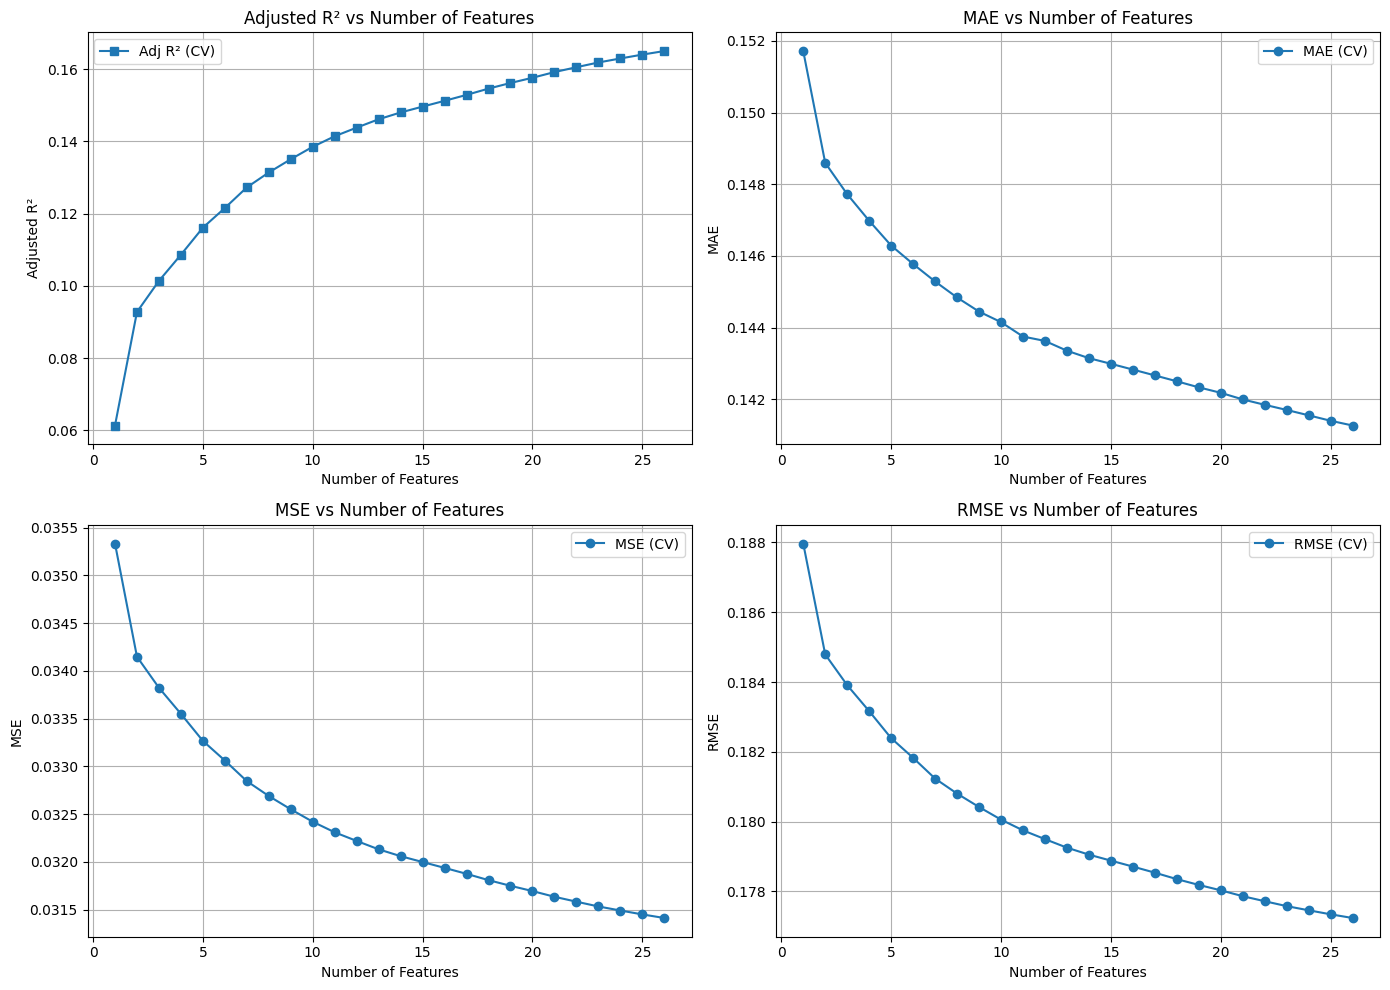

['Genre_count', 'Categories_steam cloud', 'Mac', 'Genre_visual novel', 'Categories_full controller support', 'Genre_simulation', 'Genre_action', 'Genre_pixel graphics', 'Languages_japanese', 'Genre_great soundtrack', 'Genre_massively multiplayer', 'Genre_free to play', 'Genre_funny', 'Genre_survival', 'Genre_violent', 'Categories_steam achievements', 'Genre_classic', 'Developers_Developers_Other', 'Genre_vr only', 'Price', 'Genre_cute', 'Categories_steam workshop', 'Categories_in-app purchases', 'Genre_puzzle', 'Genre_', 'Days_since_release']
LinearRegression()


In [149]:
best_scores, metrics, selected_features = forward_stepwise_selection(df, features, 'PositivityRate', plot = True)
print(best_scores['r2']['features']) 
print(best_scores['r2']['model'])


Starting Backward Stepwise Selection for target: 'PositivityRate'
------------------------------------------------------------
Removed: Genre_utilities                | R² CV: 0.1896 | Adj R² CV: 0.1825 | MAE CV: 0.1388 | MSE CV: 0.0305 | RMSE CV: 0.1747 | Features left: 456
Removed: Genre_idler                    | R² CV: 0.1896 | Adj R² CV: 0.1826 | MAE CV: 0.1388 | MSE CV: 0.0305 | RMSE CV: 0.1747 | Features left: 455
🔹 Stopping early: R² improvement 0.000050 is less than threshold 0.001
------------------------------------------------------------
Best subsets by metric:
  R2: 0.1897 with 455 features
  MAE: 0.1388 with 455 features
  MSE: 0.0305 with 455 features
  RMSE: 0.1746 with 455 features


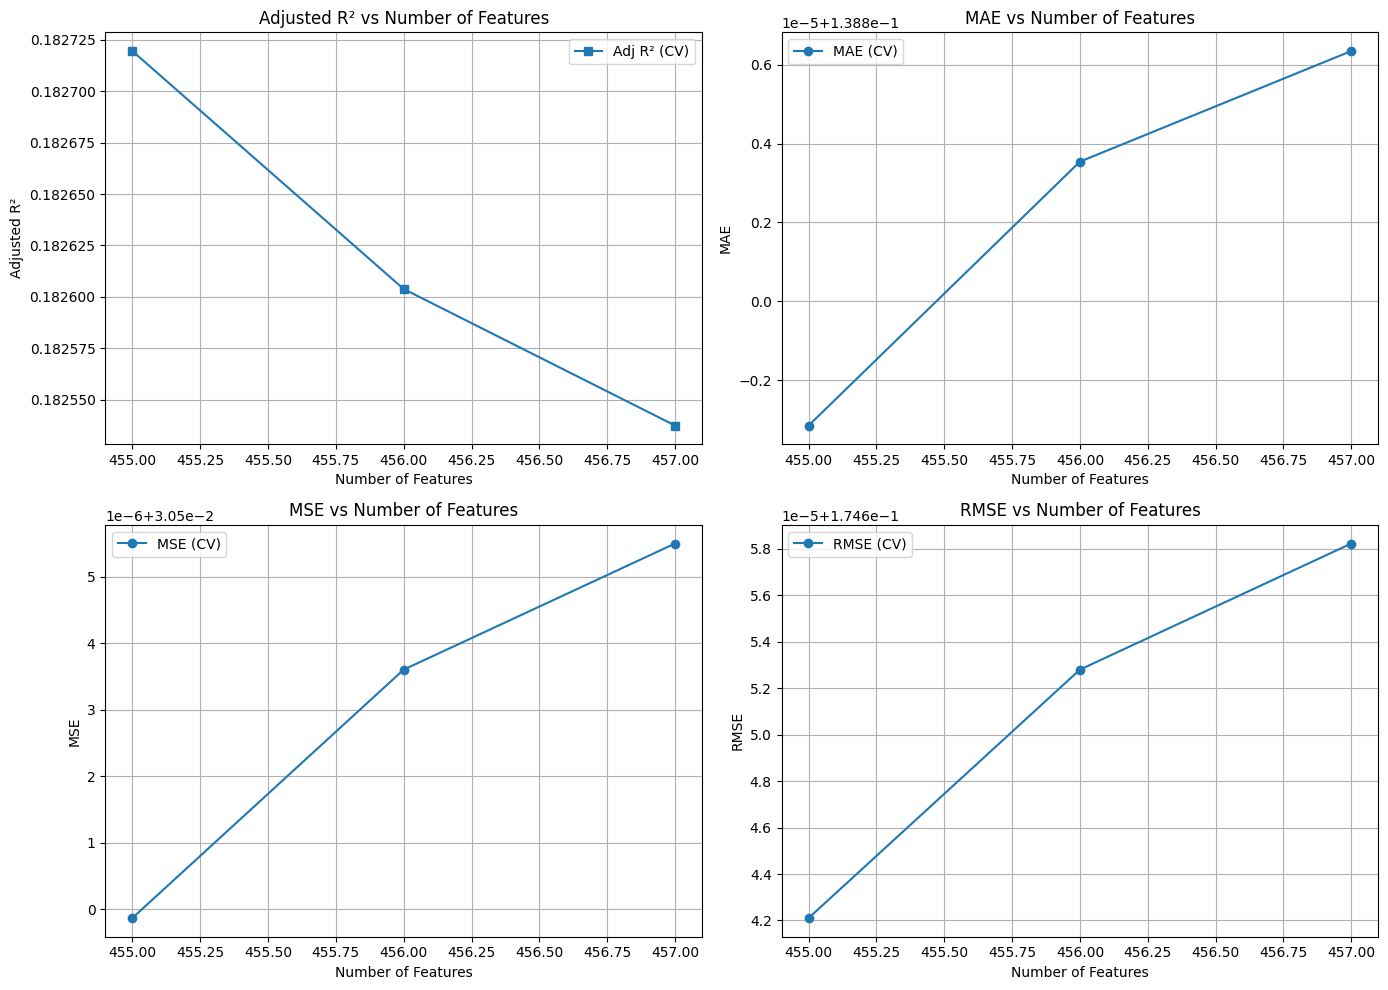

['Required age', 'Price', 'DLC count', 'Mac', 'Linux', 'Achievements', 'Title length', 'Title_word_count', 'Title_avg_word_len', 'Title Has Number', 'HasWebsite', 'HasSupport', 'Description length', 'Description_word_count', 'Num_Screenshots', 'Num_Movies', 'Description_punct_count', 'TitleLetter_A', 'TitleLetter_A', 'TitleLetter_B', 'TitleLetter_B', 'TitleLetter_C', 'TitleLetter_C', 'TitleLetter_D', 'TitleLetter_D', 'TitleLetter_E', 'TitleLetter_E', 'TitleLetter_F', 'TitleLetter_F', 'TitleLetter_G', 'TitleLetter_G', 'TitleLetter_H', 'TitleLetter_H', 'TitleLetter_I', 'TitleLetter_I', 'TitleLetter_K', 'TitleLetter_K', 'TitleLetter_L', 'TitleLetter_L', 'TitleLetter_M', 'TitleLetter_M', 'TitleLetter_N', 'TitleLetter_N', 'TitleLetter_O', 'TitleLetter_O', 'TitleLetter_P', 'TitleLetter_P', 'TitleLetter_R', 'TitleLetter_R', 'TitleLetter_S', 'TitleLetter_S', 'TitleLetter_T', 'TitleLetter_T', 'TitleLetter_U', 'TitleLetter_U', 'TitleLetter_V', 'TitleLetter_V', 'TitleLetter_W', 'TitleLetter_W', "

In [150]:
best_scores_2, metrics_2, selected_features_2  = backward_stepwise_selection(df, features, 'PositivityRate', plot = True)
print(best_scores_2['r2']['features']) 
print(best_scores_2['r2']['model'])


Starting Mixed Stepwise Selection for target: 'PositivityRate'
------------------------------------------------------------
[Iteration 1] Added feature: Genre_count | CV Adj R²: 0.0613
[Iteration 1] Current features: ['Genre_count']
R² CV: 0.0613 | Adj R² CV: 0.0613 | MAE CV: 0.1517 | MSE CV: 0.0353 | RMSE CV: 0.1880

[Iteration 2] Added feature: Categories_steam cloud | CV Adj R²: 0.0928
[Iteration 2] Did NOT remove feature: Genre_count (p=0.0000), no CV Adj R² improvement
[Iteration 2] Current features: ['Genre_count', 'Categories_steam cloud']
R² CV: 0.0928 | Adj R² CV: 0.0928 | MAE CV: 0.1486 | MSE CV: 0.0341 | RMSE CV: 0.1848

[Iteration 3] Added feature: Mac | CV Adj R²: 0.1014
[Iteration 3] Did NOT remove feature: Mac (p=0.0000), no CV Adj R² improvement
[Iteration 3] Current features: ['Genre_count', 'Categories_steam cloud', 'Mac']
R² CV: 0.1014 | Adj R² CV: 0.1014 | MAE CV: 0.1477 | MSE CV: 0.0338 | RMSE CV: 0.1839

[Iteration 4] Added feature: Genre_visual novel | CV Adj R²

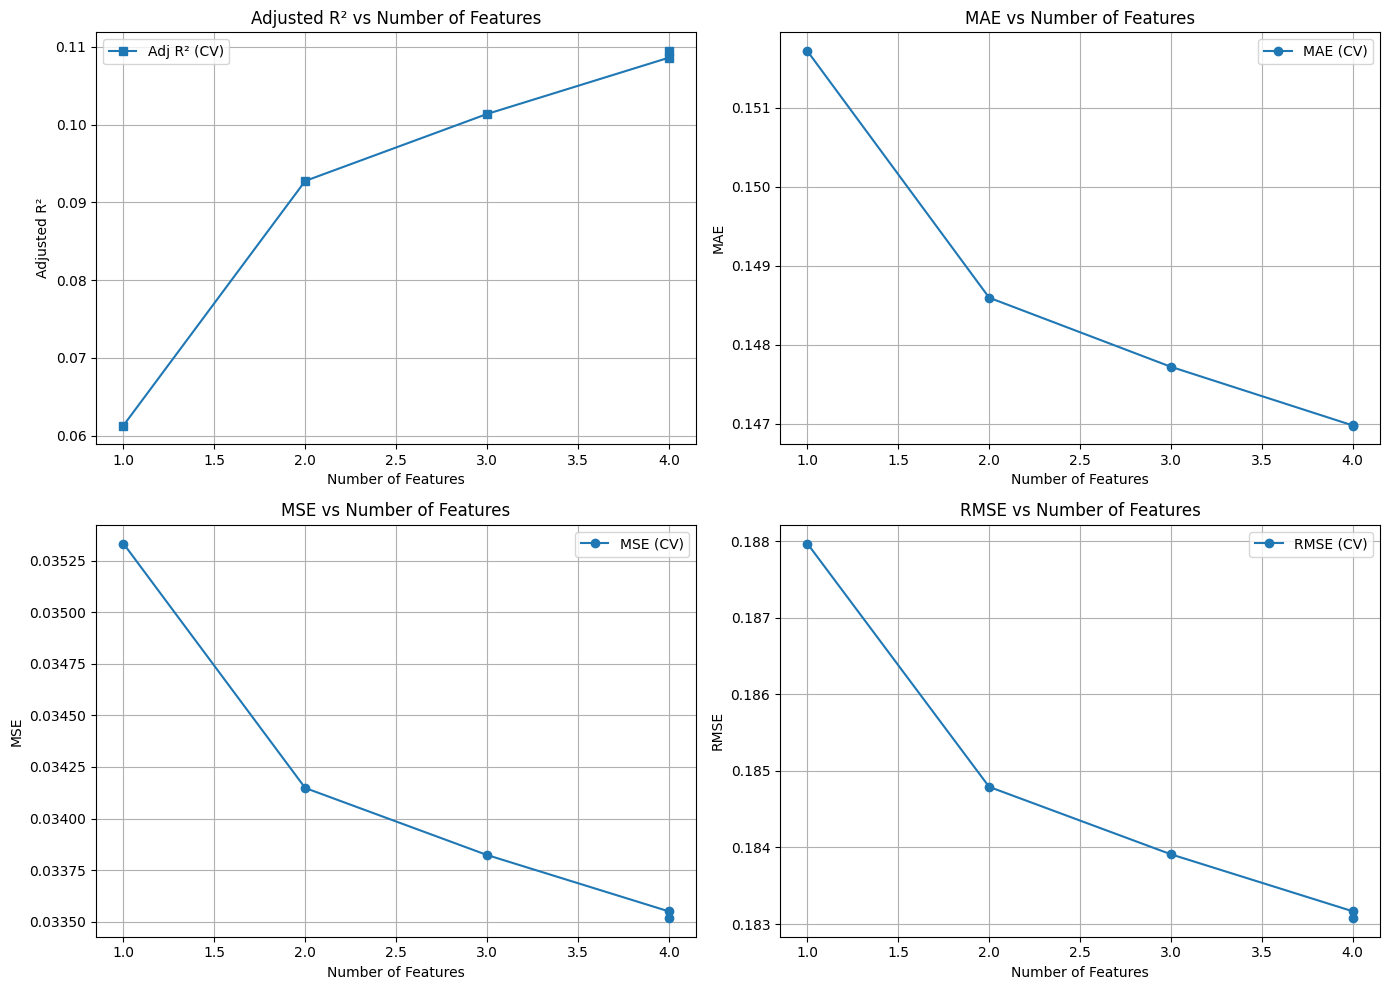

['Genre_count', 'Categories_steam cloud', 'Genre_visual novel', 'Categories_full controller support']
LinearRegression()


In [151]:
best_scores_3, metrics_3, selected_features_3  = mixed_stepwise_selection(df, features, 'PositivityRate', plot = True)
print(best_scores_3['r2']['features']) 
print(best_scores_3['r2']['model'])


=== Running for Target: Metacritic score ===
🔹 Forward Selection for Metacritic score
🔹 Backward Selection for Metacritic score
🔹 Mixed Selection for Metacritic score

=== Running for Target: Average playtime forever ===
🔹 Forward Selection for Average playtime forever
🔹 Backward Selection for Average playtime forever
🔹 Mixed Selection for Average playtime forever

=== Running for Target: PositivityRate ===
🔹 Forward Selection for PositivityRate
🔹 Backward Selection for PositivityRate
🔹 Mixed Selection for PositivityRate

=== Running for Target: Recommendations ===
🔹 Forward Selection for Recommendations
🔹 Backward Selection for Recommendations
🔹 Mixed Selection for Recommendations

=== Running for Target: Number Of Reviews ===
🔹 Forward Selection for Number Of Reviews
🔹 Backward Selection for Number Of Reviews
🔹 Mixed Selection for Number Of Reviews

=== Running for Target: Estimated owners ===
Skipping categorical target: Estimated owners

=== Running for Target: Review_Category ===

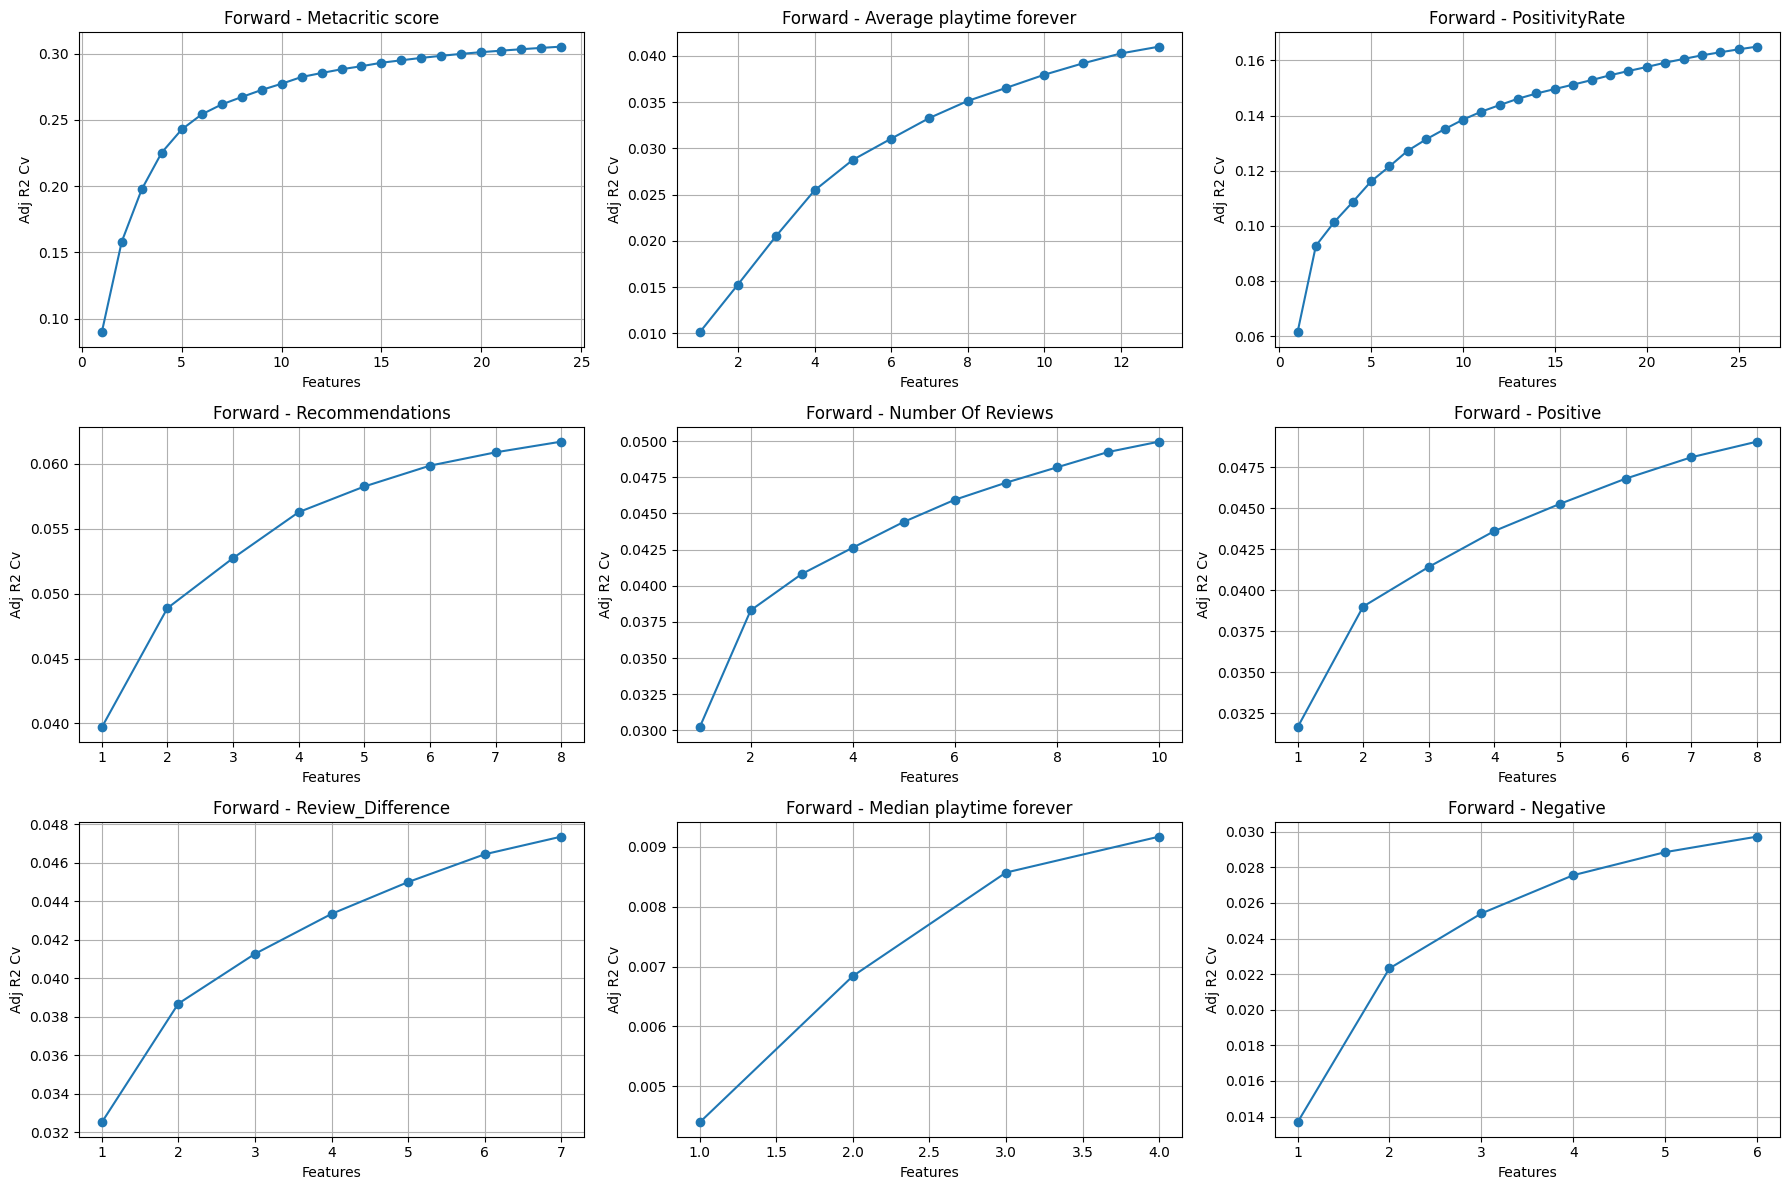

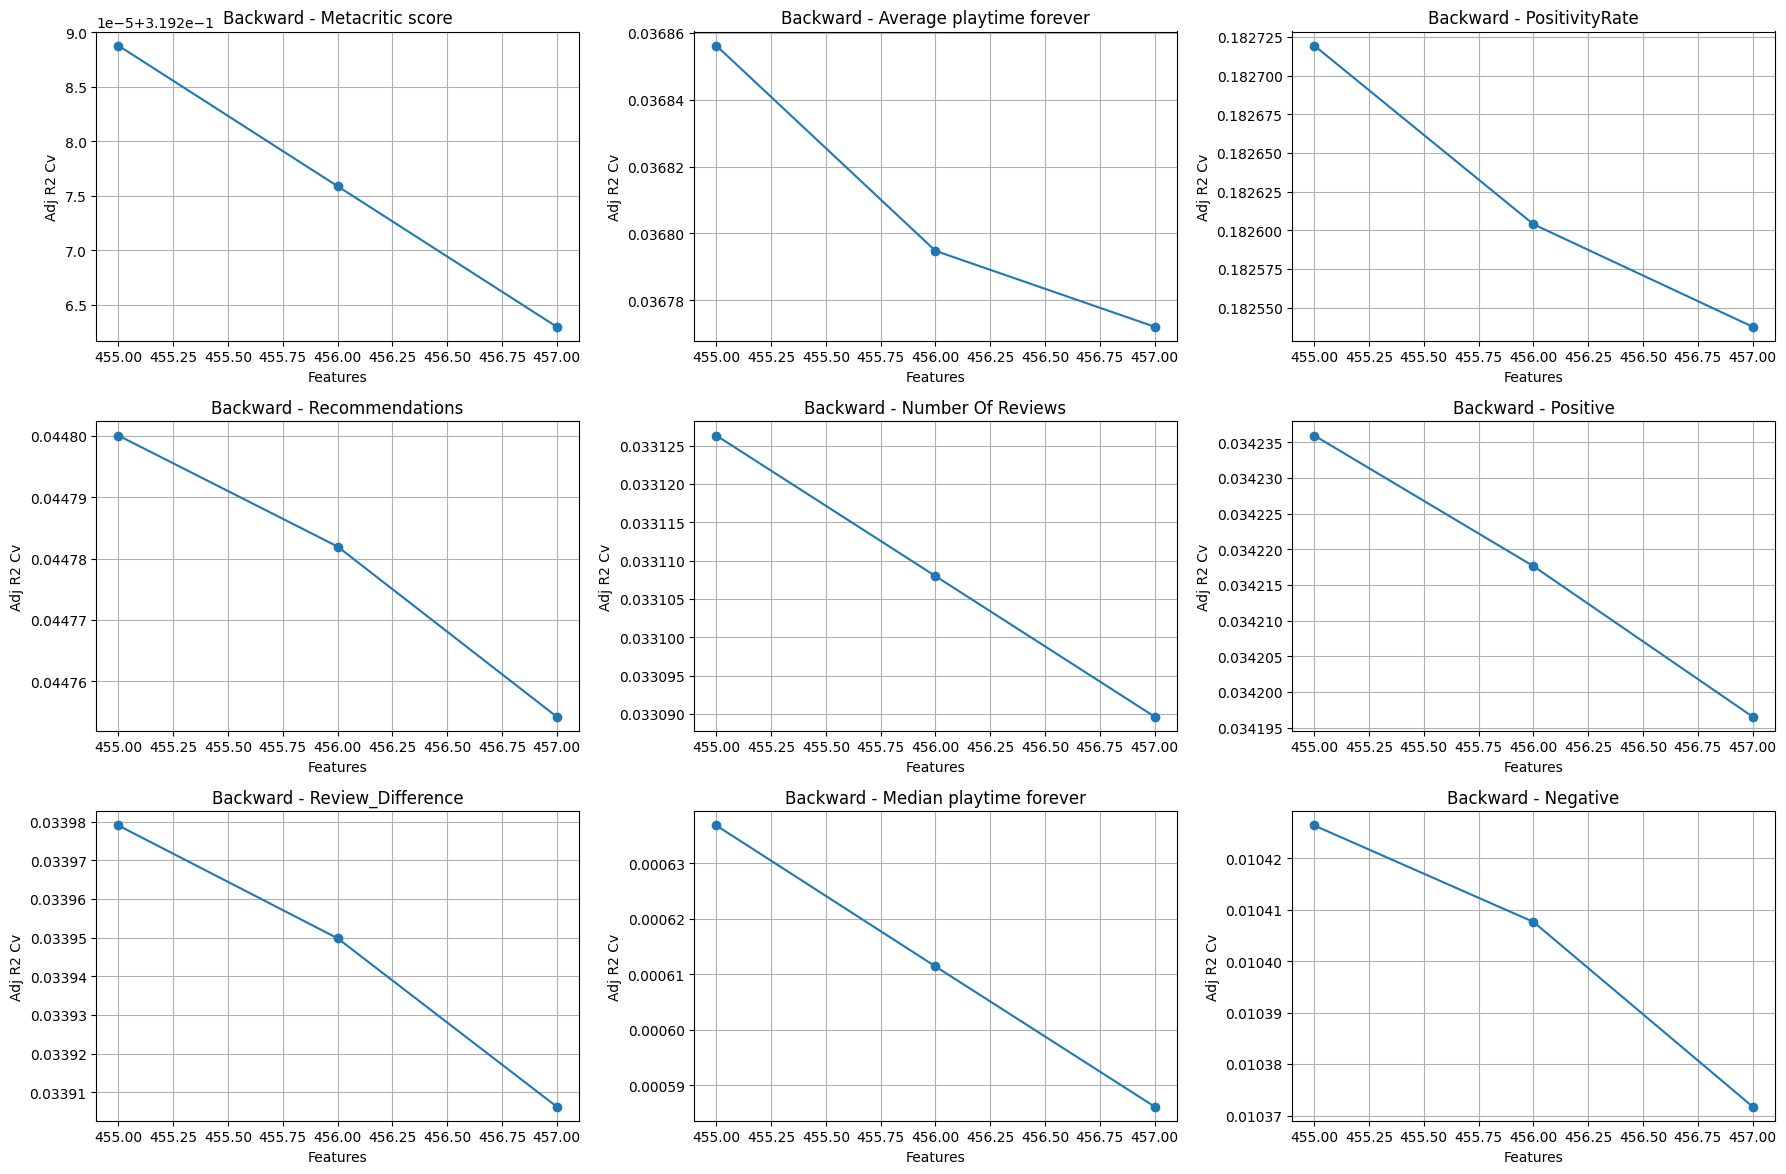

TypeError: tuple indices must be integers or slices, not str

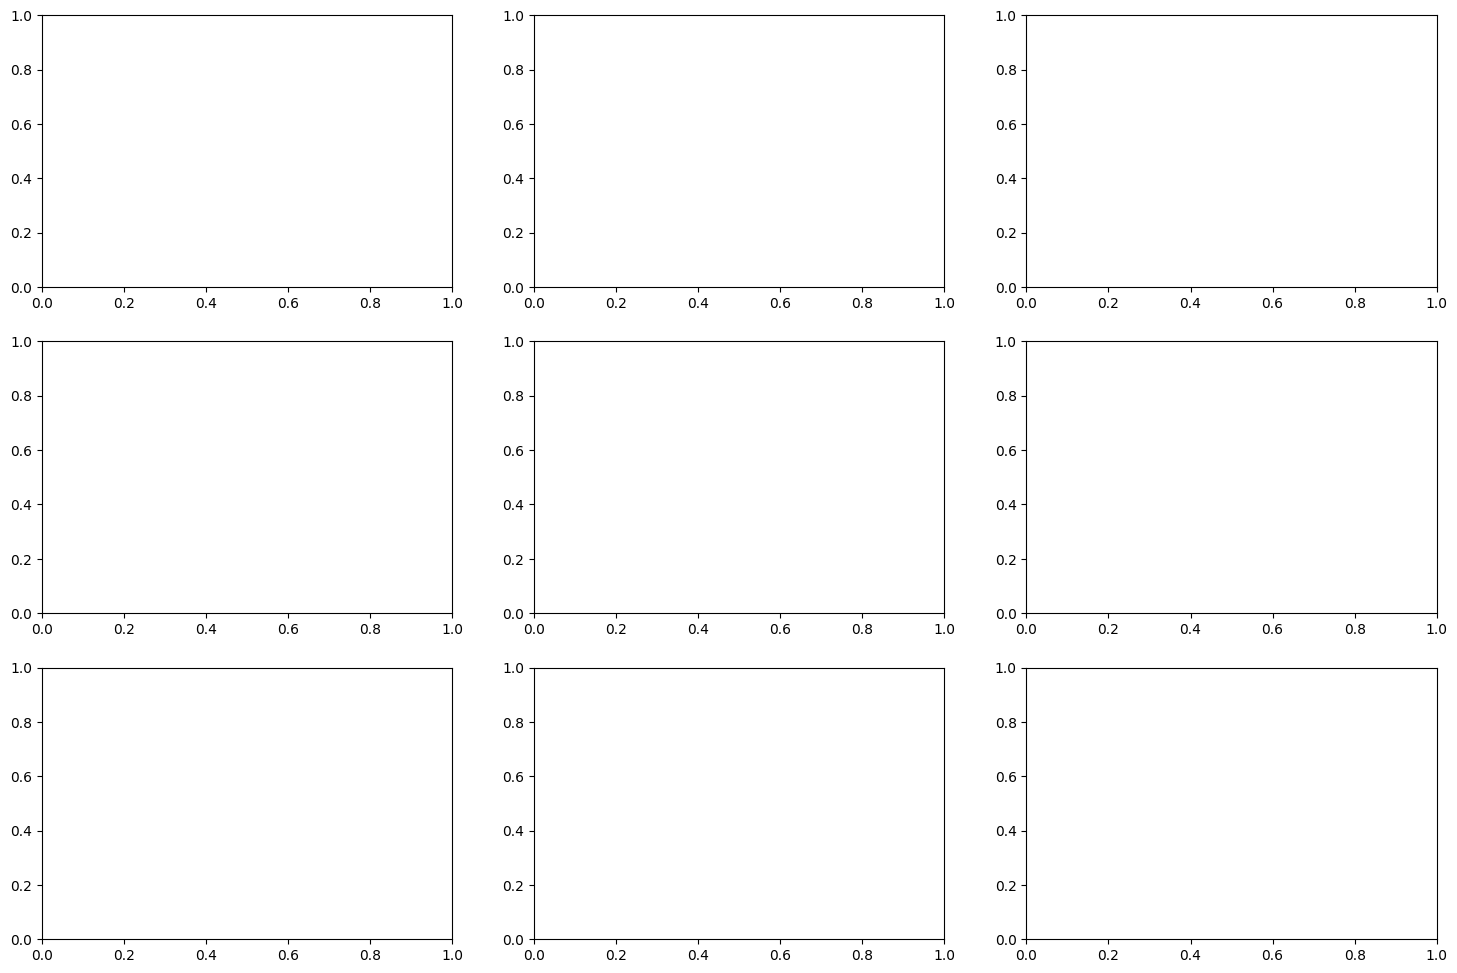

In [152]:
Main_targets = ['PositivityRate', 'Metacritic score', 'Review_Category', 'Review_Category_Simplified', 'Review_Difference']
additional_targets = ['Estimated owners', 'Recommendations', 'Positive', 'Negative', 'Number Of Reviews', 'Average playtime forever', 'Median playtime forever']
numerical_targets = ['PositivityRate', 'Metacritic score', 'Recommendations', 'Positive', 'Negative', 'Number Of Reviews', 'Average playtime forever', 'Median playtime forever']
categorical_targets = ['Review_Category', 'Review_Category_Simplified', 'Estimated owners']
targets = list(set(Main_targets + additional_targets))

# Containers to store results
results = {
    'forward': {},
    'backward': {},
    'mixed': {}
}

# Run feature selection for each target
for target in targets:
    print(f"\n=== Running for Target: {target} ===")
    
    # Skip targets that are not numerical
    if target in categorical_targets:
        print(f"Skipping categorical target: {target}")
        continue

    # Forward Selection
    print(f"🔹 Forward Selection for {target}")
    f_scores, f_metrics, f_features = forward_stepwise_selection(df, features, target, plot=False, verbose=False)
    results['forward'][target] = {'scores': f_scores, 'metrics': f_metrics, 'features': f_features}

    # Backward Selection
    print(f"🔹 Backward Selection for {target}")
    b_scores, b_metrics, b_features = backward_stepwise_selection(df, features, target, plot=False, verbose=False)
    results['backward'][target] = {'scores': b_scores, 'metrics': b_metrics, 'features': b_features}

    # Mixed Selection
    print(f"🔹 Mixed Selection for {target}")
    m_output = mixed_stepwise_selection(df, features, target, plot=False, verbose=False)
    results['mixed'][target] = m_output


# Plotting Results (Adjusted R²)
def plot_all_selection_metrics(results, metric='adj_r2_cv', method='forward'):
    targets = list(results[method].keys())
    n = len(targets)
    cols = 3
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4))
    axes = axes.flatten()

    for i, target in enumerate(targets):
        ax = axes[i]
        data = results[method][target]['metrics']
        if metric in data:
            ax.plot(data['num_features'] if 'num_features' in data else data['k'], data[metric], marker='o')
            ax.set_title(f"{method.title()} - {target}")
            ax.set_xlabel("Features")
            ax.set_ylabel(metric.replace("_", " ").title())
            ax.grid(True)
        else:
            ax.set_visible(False)

    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()


# Example usage: Plot all forward selection adjusted R²s
plot_all_selection_metrics(results, method='forward', metric='adj_r2_cv')
plot_all_selection_metrics(results, method='backward', metric='adj_r2_cv')
plot_all_selection_metrics(results, method='mixed', metric='adj_r2_cv')

Decision Trees

In [ ]:
def run_random_forest_analysis(df, target_col, excluded_columns, top_n=10, verbose=True):
    if target_col == 'Metacritic score':
        df = filter_valid_target(df, 'Metacritic score')
    # Determine whether this is regression or classification
    is_classification = df[target_col].dtype == 'object' or target_col in categorical_targets

    # Define features: exclude targets
    features = [col for col in df.columns if col not in excluded_columns and col != target_col]

    X = df[features].copy()
    y = df[target_col].copy()

    # Drop rows with missing values in target or features
    data = pd.concat([X, y], axis=1).dropna()
    X = data[features]
    y = data[target_col]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train model
    if is_classification:
        model = RandomForestClassifier(n_estimators=100, random_state=42)
    else:
        model = RandomForestRegressor(n_estimators=100, random_state=42)

    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Evaluate
    if is_classification:
        score = accuracy_score(y_test, y_pred)
        score_name = "Accuracy"
    else:
        score = r2_score(y_test, y_pred)
        score_name = "R²"

    # Feature importances
    importances = model.feature_importances_
    feature_importances = pd.DataFrame({
        'feature': features,
        'importance': importances
    }).sort_values(by='importance', ascending=False)

    top_features = feature_importances.head(top_n)['feature'].tolist()

    if verbose:
        print(f"✅ Target: {target_col}")
        print(f"{score_name}: {score:.4f}")
        print("Top features:")
        print(feature_importances.head(top_n))
        print("-" * 50)

    return {
        'target': target_col,
        'score': score,
        'score_name': score_name,
        'top_features': top_features,
        'model': model,
        'feature_importances': feature_importances
    }

In [ ]:
results = []
targets = Main_targets + additional_targets

for target in targets:
    # Exclude all targets except the current one
    excluded_columns = [t for t in targets if t != target]
    
    result = run_random_forest_analysis(df, target, excluded_columns)
    results.append(result)

for res in results:
    print(f"{res['target']:<30} {res['score_name']}: {res['score']:.4f}")

✅ Target: PositivityRate
R²: 0.2282
Top features:
                      feature  importance
2147       Days_since_release    0.074727
2269              Genre_count    0.073432
6                Achievements    0.065109
1                       Price    0.046348
9          Title_avg_word_len    0.044638
17    Description_punct_count    0.044593
13         Description length    0.043361
7                Title length    0.042767
14     Description_word_count    0.038852
15            Num_Screenshots    0.033653
--------------------------------------------------
Total rows with valid 'Metacritic score': 3862
✅ Target: Metacritic score
R²: 0.2216
Top features:
                      feature  importance
2269              Genre_count    0.150068
2147       Days_since_release    0.083459
1                       Price    0.041677
7                Title length    0.038076
6                Achievements    0.034961
17    Description_punct_count    0.034505
15            Num_Screenshots    0.034211
14

In [ ]:
def run_GradientBoosting_analysis(df, target_col, excluded_columns, top_n = 5, verbose=True):
    if target_col == 'Metacritic score':
        df = filter_valid_target(df, 'Metacritic score')
    # Determine whether this is regression or classification
    is_classification = df[target_col].dtype == 'object' or target_col in categorical_targets

    # Define features: exclude targets
    features = [col for col in df.columns if col not in excluded_columns and col != target_col]

    X = df[features].copy()
    y = df[target_col].copy()

    # Drop rows with missing values in target or features
    data = pd.concat([X, y], axis=1).dropna()
    X = data[features]
    y = data[target_col]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train model
    if is_classification:
        model = GradientBoostingClassifier(n_estimators=100, random_state=42)
    else:
        model = GradientBoostingRegressor(n_estimators=100, random_state=42)

    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Evaluate
    if is_classification:
        score = accuracy_score(y_test, y_pred)
        score_name = "Accuracy"
    else:
        score = r2_score(y_test, y_pred)
        score_name = "R²"

    # Feature importances
    importances = model.feature_importances_
    feature_importances = pd.DataFrame({
        'feature': features,
        'importance': importances
    }).sort_values(by='importance', ascending=False)

    top_features = feature_importances.head(top_n)['feature'].tolist()

    if verbose:
        print(f"✅ Target: {target_col}")
        print(f"{score_name}: {score:.4f}")
        print("Top features:")
        print(feature_importances.head(top_n))
        print("-" * 50)

    return {
        'target': target_col,
        'score': score,
        'score_name': score_name,
        'top_features': top_features,
        'model': model,
        'feature_importances': feature_importances
    }

In [13]:
results = []
targets = Main_targets + additional_targets

for target in targets:
    result = run_GradientBoosting_analysis(df, target, excluded_columns)
    results.append(result)

for res in results:
    print(f"{res['target']:<30} {res['score_name']}: {res['score']:.4f}")

✅ Target: PositivityRate
R²: 0.2001
Top features:
                     feature  importance
2269             Genre_count    0.188833
6               Achievements    0.150806
2192  Categories_steam cloud    0.123065
2147      Days_since_release    0.061932
1                      Price    0.041419
--------------------------------------------------
Total rows with valid 'Metacritic score': 3862
✅ Target: Metacritic score
R²: 0.2352
Top features:
                     feature  importance
2269             Genre_count    0.299975
2147      Days_since_release    0.134701
1                      Price    0.044581
2207                Genre_2d    0.028142
14    Description_word_count    0.026738
--------------------------------------------------
✅ Target: Review_Category
Accuracy: 0.4318
Top features:
                             feature  importance
2147              Days_since_release    0.205918
1                              Price    0.085970
2269                     Genre_count    0.066702
2194

KeyboardInterrupt: 

Cross Validation


In [ ]:

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
def cross_validate_top_n_features(df, target_col, excluded_columns, 
                                  top_n_list=[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70], 
                                  cv=5, min_improvement=0.001):
    scores = []
    best_score = -float('inf')
    prev_best_score = -float('inf')
    
    for top_n in top_n_list:
        result = run_random_forest_analysis(df, target_col, excluded_columns, top_n=top_n, verbose=False)
        
        top_features = result['top_features']
        X = df[top_features].copy()
        y = df[target_col].copy()
        
        # Drop rows with missing values
        data = pd.concat([X, y], axis=1).dropna()
        X = data[top_features]
        y = data[target_col]
        
        is_classification = y.dtype == 'object' or target_col in categorical_targets
        
        if is_classification:
            model = RandomForestClassifier(n_estimators=100, random_state=42)
            scoring = 'accuracy'
        else:
            model = RandomForestRegressor(n_estimators=100, random_state=42)
            scoring = 'r2'
        
        score = cross_val_score(model, X, y, cv=cv, scoring=scoring).mean()
        scores.append((top_n, score, result))
        print(f"Top {top_n} features → CV {scoring}: {score:.4f}")
        
        # Early stopping check
        improvement = score - prev_best_score
        if improvement < min_improvement:
            print(f"🔹 Early stopping: Improvement {improvement:.6f} < threshold {min_improvement}")
            break
        
        prev_best_score = score
    
    # Choose best top_n from all evaluated so far
    best_n, best_score, best_result = max(scores, key=lambda x: x[1])
    print(f"\n✅ Best number of features: {best_n} → CV Score: {best_score:.4f}")
    
    return best_result

In [ ]:
# List of target columns
targets = [
    'PositivityRate',
    'Metacritic score',
    'Review_Category',
    'Review_Category_Simplified',
    'Review_Difference',
    'Estimated owners',
    'Recommendations',
    'Positive',
    'Negative',
    'Number Of Reviews',
    'Average playtime forever',
    'Median playtime forever'
]

# Store all results
cv_results = []

# Loop through targets
for target in targets:
    print(f"\n🔍 Cross-validating for: {target}")
    try:
        result = cross_validate_top_n_features(
            df=df,
            target_col=target,
            excluded_columns=excluded_columns,
            top_n_list=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150],
            cv=5
        )
        cv_results.append(result)
    except Exception as e:
        print(f"❌ Failed for {target}: {e}")


🔍 Cross-validating for: PositivityRate
Top 10 features → CV r2: 0.1039
Top 20 features → CV r2: 0.1483
Top 30 features → CV r2: 0.1785
Top 40 features → CV r2: 0.1841
Top 50 features → CV r2: 0.1854
Top 60 features → CV r2: 0.1908
Top 70 features → CV r2: 0.1917
Top 80 features → CV r2: 0.1941
Top 90 features → CV r2: 0.1958
Top 100 features → CV r2: 0.1964
Top 110 features → CV r2: 0.1971
Top 120 features → CV r2: 0.1973
Top 130 features → CV r2: 0.1983
Top 140 features → CV r2: 0.1982
Top 150 features → CV r2: 0.1980

✅ Best number of features: 130 → CV Score: 0.1983

🔍 Cross-validating for: Metacritic score
Total rows with valid 'Metacritic score': 3862
Top 10 features → CV r2: 0.2578
Total rows with valid 'Metacritic score': 3862
Top 20 features → CV r2: 0.3025
Total rows with valid 'Metacritic score': 3862
Top 30 features → CV r2: 0.3197
Total rows with valid 'Metacritic score': 3862
Top 40 features → CV r2: 0.3190
Total rows with valid 'Metacritic score': 3862
Top 50 features → 

C:\Users\wille\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Top 10 features → CV accuracy: 0.6712


C:\Users\wille\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Top 20 features → CV accuracy: 0.6927


C:\Users\wille\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Top 30 features → CV accuracy: 0.6967


C:\Users\wille\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Top 40 features → CV accuracy: 0.6990


C:\Users\wille\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Top 50 features → CV accuracy: 0.6970


C:\Users\wille\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Top 60 features → CV accuracy: 0.6979


C:\Users\wille\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Top 70 features → CV accuracy: 0.6987


C:\Users\wille\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Top 80 features → CV accuracy: 0.6974


C:\Users\wille\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Top 90 features → CV accuracy: 0.6974


C:\Users\wille\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Top 100 features → CV accuracy: 0.6978


C:\Users\wille\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Top 110 features → CV accuracy: 0.6967


C:\Users\wille\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Top 120 features → CV accuracy: 0.6973


C:\Users\wille\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Top 130 features → CV accuracy: 0.6971


C:\Users\wille\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Top 140 features → CV accuracy: 0.6950


C:\Users\wille\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Top 150 features → CV accuracy: 0.6956

✅ Best number of features: 40 → CV Score: 0.6990

🔍 Cross-validating for: Recommendations
Top 10 features → CV r2: -0.6067
Top 20 features → CV r2: -0.5420
Top 30 features → CV r2: -0.6457
Top 40 features → CV r2: -0.5867
Top 50 features → CV r2: -0.5606
Top 60 features → CV r2: -0.5865
Top 70 features → CV r2: -0.5483
Top 80 features → CV r2: -0.5167
Top 90 features → CV r2: -0.5014
Top 100 features → CV r2: -0.5225
Top 110 features → CV r2: -0.5443
Top 120 features → CV r2: -0.5373
Top 130 features → CV r2: -0.5464
Top 140 features → CV r2: -0.5257
Top 150 features → CV r2: -0.5339

✅ Best number of features: 90 → CV Score: -0.5014

🔍 Cross-validating for: Positive
Top 10 features → CV r2: 0.5030
Top 20 features → CV r2: 0.5515
Top 30 features → CV r2: 0.5616
Top 40 features → CV r2: 0.5688
Top 50 features → CV r2: 0.5715
Top 60 features → CV r2: 0.5720
Top 70 features → CV r2: 0.5728
Top 80 features → CV r2: 0.5731
Top 90 features → CV r2: 0.5

In [ ]:
def plot_cv_results(cv_results, metric='score', targets_to_plot=None):
    plt.figure(figsize=(12, 8))

    for result in cv_results:
        target = result['target']
        if targets_to_plot and target not in targets_to_plot:
            continue

        top_n = result['top_features']
        scores = result[metric]  # 'scores' contains the CV scores

        plt.plot(top_n, scores, marker='o', label=target)

    plt.title(f"Cross-Validation {metric.upper()} over Number of Features")
    plt.xlabel("Number of Top Features Used")
    plt.ylabel(metric.upper())
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


print(cv_results[0])

{'target': 'PositivityRate', 'score': 0.2281846372853319, 'score_name': 'R²', 'top_features': ['Days_since_release', 'Genre_count', 'Achievements', 'Price', 'Title_avg_word_len', 'Description_punct_count', 'Description length', 'Title length', 'Description_word_count', 'Num_Screenshots', 'Categories_steam cloud', 'Categories_count', 'Languages_count', 'Title_word_count', 'Num_Movies', 'Release_year', 'Genre_action', 'Genre_simulation', 'DLC count', 'HasWebsite', 'Genre_adventure', 'PlatformSupport_count', 'Genre_casual', 'Genre_cute', 'Genre_puzzle', 'Genre_strategy', 'Genre_2d', 'Genre_indie', 'Categories_full controller support', 'Genre_early access', 'Genre_pixel graphics', 'Genre_rpg', 'DescLetter_T', 'Genre_singleplayer', 'Genre_story rich', 'TitleLetter_T', 'TitleLetter_S', 'DescLetter_A', 'Genre_first-person', 'Categories_partial controller support', 'Genre_3d', 'DescLetter_I', 'Languages_simplified chinese', 'Mac', 'TitleLetter_A', 'TitleLetter_C', 'Developers_count', 'TitleLet

In [21]:

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier

def cross_validate_gb_top_n_features(df, target_col, excluded_columns, top_n_list=[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70], cv=5):
    if target_col == 'Metacritic score':
        df = filter_valid_target(df, 'Metacritic score')

    is_classification = df[target_col].dtype == 'object' or target_col in categorical_targets
    scoring = 'accuracy' if is_classification else 'r2'

    features = [col for col in df.columns if col not in excluded_columns and col != target_col]

    X = df[features].copy()
    y = df[target_col].copy()

    data = pd.concat([X, y], axis=1).dropna()
    X = data[features]
    y = data[target_col]

    # Full model to get feature importances
    if is_classification:
        model = GradientBoostingClassifier(n_estimators=100, random_state=42)
    else:
        model = GradientBoostingRegressor(n_estimators=100, random_state=42)

    model.fit(X, y)
    importances = model.feature_importances_
    feature_importances = pd.DataFrame({
        'feature': features,
        'importance': importances
    }).sort_values(by='importance', ascending=False)

    results = []

    for top_n in top_n_list:
        top_features = feature_importances.head(top_n)['feature'].tolist()
        X_top = X[top_features]

        if is_classification:
            model_cv = GradientBoostingClassifier(n_estimators=100, random_state=42)
        else:
            model_cv = GradientBoostingRegressor(n_estimators=100, random_state=42)

        scores = cross_val_score(model_cv, X_top, y, cv=cv, scoring=scoring)
        avg_score = scores.mean()

        results.append({
            'target': target_col,
            'top_n': top_n,
            'score': avg_score,
            'score_name': 'Accuracy' if is_classification else 'R²',
            'top_features': top_features
        })

    # Return best scoring top_n
    best_result = max(results, key=lambda x: x['score'])
    return best_result

In [19]:
gb_results = []

for target in targets:
    print(f"\n🔍 Gradient Boosting CV for: {target}")
    try:
        result = cross_validate_gb_top_n_features(
            df=df,
            target_col=target,
            excluded_columns=excluded_columns,
            top_n_list=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150],
            cv=5
        )
        gb_results.append(result)
    except Exception as e:
        print(f"❌ Failed for {target}: {e}")


🔍 Gradient Boosting CV for: PositivityRate

🔍 Gradient Boosting CV for: Metacritic score
Total rows with valid 'Metacritic score': 3862

🔍 Gradient Boosting CV for: Review_Category

🔍 Gradient Boosting CV for: Review_Category_Simplified


KeyboardInterrupt: 